In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from autoviz.AutoViz_Class import AutoViz_Class
from matplotlib.backends.backend_pdf import PdfPages
import pickle
%matplotlib inline

Imported v0.1.904. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# EDA functions

In [2]:
def calculate_missing_percentages(dataframe):
    """
    Calculate the percentage of missing values per column in a DataFrame.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame to analyze.

    Returns:
    pandas.Series: A Series containing the percentage of missing values per column.
    """
    missing_percentages = dataframe.isna().mean() * 100
    return missing_percentages

def drop_columns_with_high_missing_percentages(dataframe, threshold=10):
    """
    Drop columns from DataFrame where missing values exceed the specified threshold.

    Parameters:
    dataframe (pandas.DataFrame): The DataFrame to analyze.
    threshold (float): The threshold percentage of missing values. Default is 10.

    Returns:
    pandas.DataFrame: DataFrame with columns dropped based on the specified threshold.
    """
    missing_percentages = calculate_missing_percentages(dataframe)
    columns_to_drop = missing_percentages[missing_percentages > threshold].index
    dataframe_dropped = dataframe.drop(columns=columns_to_drop)
    return dataframe_dropped

In [3]:
os.chdir(r'C:\Users\YKoyama\OneDrive - Carollo Engineers\General - NAWI 3.13 RO Modeling\Data Request\EDA and Modeling')

# GWRS data

In [ ]:
# read WW flow df
WW_flow = pd.read_excel('GWRS feed flow.xlsx')
WW_flow = WW_flow.iloc[:,1:].dropna(subset='Date ')
WW_flow.set_index('Date ', inplace=True)
WW_flow.head()

% total flow as P2 flow  total flow (MGD)  % flow as TF  \
Date                                                                  
2022-12-01         0.000000               130.578        0.204736     
2022-12-02         0.000000               133.758        0.204018     
2022-12-03         0.000000               126.485        0.211859     
2022-12-04         0.000000               131.821        0.188528     
2022-12-05         0.010209               104.418        0.236808     

            TF (P1) (MGD)  % flow as AS  AS (P1) (MGD)  P2 flow (MGD)  
Date                                                                   
2022-12-01     26.734        0.795264       103.844         0.000      
2022-12-02     27.289        0.795982       106.469         0.000      
2022-12-03     26.797        0.788141        99.688         0.000      
2022-12-04     24.852        0.811472       106.969         0.000      
2022-12-05     24.727        0.752983        78.625         1.066

In [ ]:
WW_flow.index.min(),WW_flow.index.max()

(Timestamp('2022-12-01 00:00:00'), Timestamp('2024-04-30 00:00:00'))

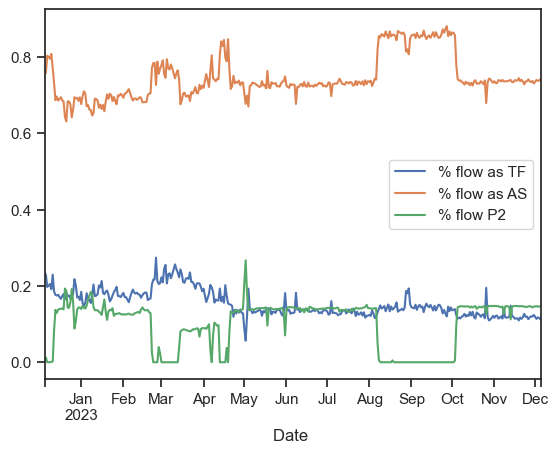

In [ ]:
fig, ax = plt.subplots()
WW_flow['% flow P2'] = WW_flow['P2 flow (MGD)']/WW_flow['total flow (MGD)']
WW_flow[['% flow as TF','% flow as AS','% flow P2']].plot(ax=ax)

#sum_ratio=WW_flow['% flow as TF']+WW_flow['% flow as AS']+WW_flow['% flow P2']
#sum_ratio.plot(label='sum of ratio')
ax.set_xlim('2022-12-05 00:00:00','2023-12-05 00:00:00')
# Remove minor tick marks from x-axis
ax.tick_params(axis='x', which='minor', length=0)
plt.legend()

# Explore RO operational 30-min data (real-time WQ)

## read from xlsx

In [4]:
df_30min_ops = pd.read_excel('data_package_2022_2023/Research dept data request - 06-10-24 - Han Gu - Q1-ROF-RO C02 E01 H02-ROP  data.xlsx',
                             header=[0, 1])
df_30min_ops.set_index([('Unnamed: 0_level_0',        'date / time')], inplace=True)
df_30min_ops.index.name='Timestamp'
df_30min_ops=df_30min_ops.stack(level=0).reset_index()
print("start timestamp is ",df_30min_ops['Timestamp'].min(), "end timestamp is", df_30min_ops['Timestamp'].max() )
df_30min_ops.head()

start timestamp is  2022-12-05 00:00:00 end timestamp is 2023-12-03 23:30:00.004000


Timestamp   level_1       NH3       NTU        EC      ROF TOC     Cl2    \
0 2022-12-05  FEED data  11.933330  4.20341         NaN      NaN       NaN   
1 2022-12-05     RO C02        NaN      NaN         NaN      NaN       NaN   
2 2022-12-05     RO E01        NaN      NaN         NaN      NaN       NaN   
3 2022-12-05     RO H02        NaN      NaN         NaN      NaN       NaN   
4 2022-12-05   ROF data   8.185695      NaN  1601.18396  9.50968  4.387215   

      pH     Temp (degF)  TOC  Concentrate  EC  Stage 1-2  EC  Stage 2-3  EC  \
0       NaN         NaN  NaN             NaN             NaN            NaN    
1       NaN         NaN  NaN     9483.555664             NaN            NaN    
2       NaN         NaN  NaN     8775.933594             NaN            NaN    
3       NaN         NaN  NaN     9171.842773     3038.566049    6701.817398    
4  6.899232   78.109833  NaN             NaN             NaN            NaN    

   Perm Stage 1  EC  Perm Stage 2  EC   Perm Stage 3  EC  Stage 1 %removal  \
0            NaN               NaN                NaN               NaN      
1      91.427879         77.742973          83.295563        100.000000      
2     503.569092        564.516724         575.028870        100.000000      
3      12.865870         29.280451          81.800110         99.473801      
4            NaN               NaN                NaN               NaN      

   Stage 2  %removal  Stage 3 %removal  Unit AFBC %removal  Permeate flow  \
0            NaN                NaN                NaN               NaN    
1     100.000000         100.000000         100.000000          0.000000    
2     100.000000         100.000000         100.000000          0.000000    
3      99.295776          99.132843          99.478828       3311.604004    
4            NaN                NaN                NaN               NaN    

   Concentrate flow  Stage 2 Perm flow  Stage 3 Perm flow  
0            NaN                NaN               NaN      
1       0.000000           0.000000          0.000000      
2       0.000000           0.000000          0.000000      
3     584.336914        1122.792969        338.014404      
4            NaN                NaN               NaN

In [ ]:
df_30min_ops.columns

## read from csvs

In [5]:
df_30min_dict = {'FEED':[], 'ROF':[], "C02":[], "E01":[], "H02":[]}
for k in df_30min_dict.keys():
    #print(df_30min_dict[k])
    #df_30min_dict[k] = df_30min_ops[df_30min_ops['level_1'].str.contains(k)]
    #df_30min_dict[k].to_csv(k+'.csv')
    df_30min_dict[k] = pd.read_csv(k+'.csv' )
    df_30min_dict[k] = df_30min_dict[k].iloc[:,1:]
    df_30min_dict[k].set_index(pd.to_datetime(df_30min_dict[k]['Timestamp']), inplace=True)
    df_30min_dict[k].drop(columns='Timestamp', inplace=True)

In [8]:
df_30min_dict[k].head(4)

level_1  NH3  NTU  EC  ROF TOC  Cl2  pH  Temp (degF)  TOC  \
Timestamp                                                                       
2022-12-05 00:00:00  RO H02 NaN  NaN  NaN   NaN    NaN  NaN     NaN      NaN    
2022-12-05 00:30:00  RO H02 NaN  NaN  NaN   NaN    NaN  NaN     NaN      NaN    
2022-12-05 01:00:00  RO H02 NaN  NaN  NaN   NaN    NaN  NaN     NaN      NaN    
2022-12-05 01:30:00  RO H02 NaN  NaN  NaN   NaN    NaN  NaN     NaN      NaN    

                     Concentrate  EC  Stage 1-2  EC  Stage 2-3  EC  \
Timestamp                                                            
2022-12-05 00:00:00    9171.842773     3038.566049    6701.817398    
2022-12-05 00:30:00    9108.456055     3037.133350    6694.584072    
2022-12-05 01:00:00    9088.157227     3026.876267    6679.697231    
2022-12-05 01:30:00    9051.624023     3013.516450    6660.991665    

                     Perm Stage 1  EC  Perm Stage 2  EC   Perm Stage 3  EC  \
Timestamp                                                                    
2022-12-05 00:00:00      12.86587          29.280451          81.800110      
2022-12-05 00:30:00      12.93027          27.594910          81.438553      
2022-12-05 01:00:00      12.86233          29.610979          81.746422      
2022-12-05 01:30:00      12.10653          28.775909          80.222290      

                     Stage 1 %removal  Stage 2  %removal  Stage 3 %removal  \
Timestamp                                                                    
2022-12-05 00:00:00      99.473801         99.295776          99.132843      
2022-12-05 00:30:00      99.478539         99.349693          99.155991      
2022-12-05 01:00:00      99.481377         99.304871          99.156693      
2022-12-05 01:30:00      99.514557         99.318222          99.172150      

                     Unit AFBC %removal  Permeate flow  Concentrate flow  \
Timestamp                                                                  
2022-12-05 00:00:00       99.478828       3311.604004      584.336914      
2022-12-05 00:30:00       99.487244       3253.082031      573.312622      
2022-12-05 01:00:00       99.489227       3229.860107      570.699707      
2022-12-05 01:30:00       99.492813       3226.035889      568.133606      

                     Stage 2 Perm flow  Stage 3 Perm flow  
Timestamp                                                  
2022-12-05 00:00:00     1122.792969        338.014404      
2022-12-05 00:30:00     1097.342041        329.636810      
2022-12-05 01:00:00     1094.433960        327.321014      
2022-12-05 01:30:00     1094.166992        327.226715

In [9]:
df_30min_dict.keys()

dict_keys(['FEED', 'ROF', 'C02', 'E01', 'H02'])

In [11]:
# save as xlsx
# Specify the Excel file name
excel_file = 'formatted_raw_30_min_data.xlsx'

# Create ExcelWriter object
with pd.ExcelWriter(excel_file) as writer:
    # Write each DataFrame to a separate sheet
    for sheet_name, df in df_30min_dict.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

## scatter plots for specific variables to see corerlations

In [52]:
df_30min_dict['C02'].columns

Index(['level_1', 'NH3', 'NTU', 'EC', 'ROF TOC', 'Cl2', 'pH', 'Temp (degF)',
       'TOC', 'Concentrate  EC', 'Stage 1-2  EC', 'Stage 2-3  EC',
       'Perm Stage 1  EC', 'Perm Stage 2  EC ', 'Perm Stage 3  EC',
       'Stage 1 %removal', 'Stage 2  %removal', 'Stage 3 %removal',
       'Unit AFBC %removal', 'Permeate flow', 'Concentrate flow',
       'Stage 2 Perm flow', 'Stage 3 Perm flow'],
      dtype='object')

<Axes: xlabel='Perm Stage 3  EC', ylabel='Perm Stage 1  EC'>

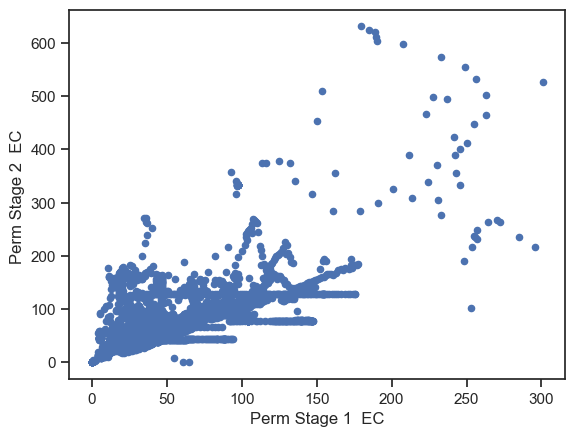

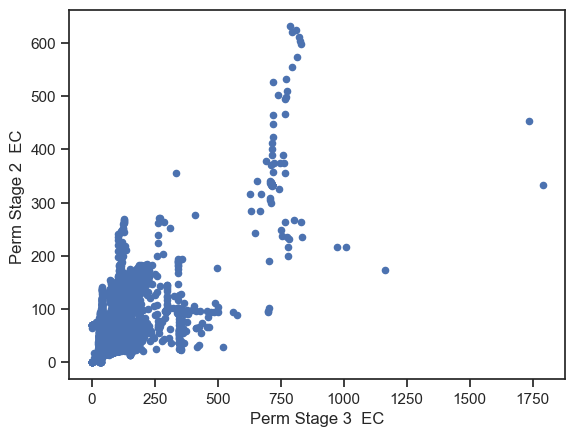

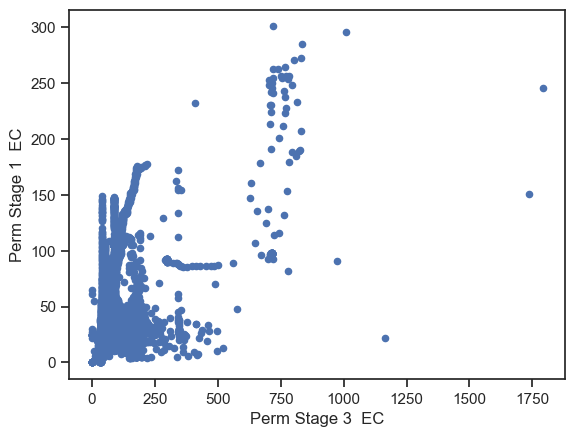

In [57]:
df_30min_dict['C02'].plot(kind='scatter',x='Perm Stage 1  EC',y='Perm Stage 2  EC ')
df_30min_dict['C02'].plot(kind='scatter',x='Perm Stage 3  EC',y='Perm Stage 2  EC ')
df_30min_dict['C02'].plot(kind='scatter',x='Perm Stage 3  EC',y='Perm Stage 1  EC')

<Axes: xlabel='Perm Stage 3  EC', ylabel='Perm Stage 1  EC'>

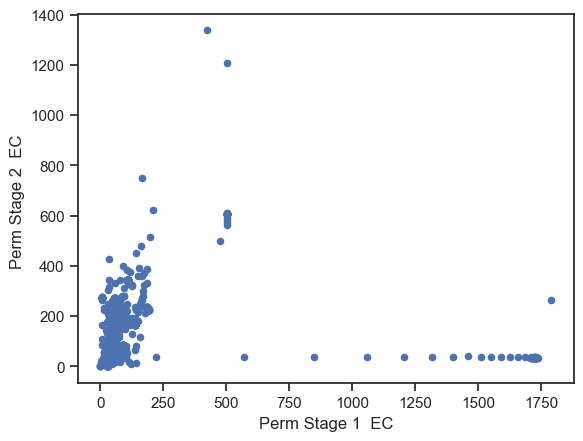

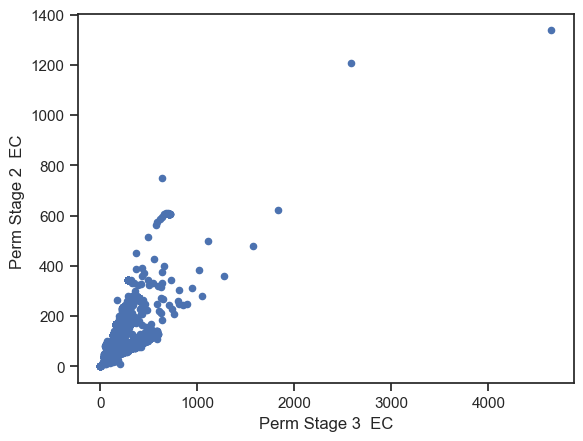

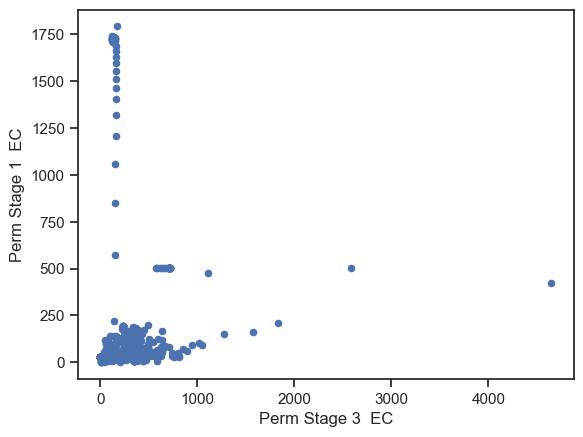

In [59]:
df_30min_dict['E01'].plot(kind='scatter',x='Perm Stage 1  EC',y='Perm Stage 2  EC ')
df_30min_dict['E01'].plot(kind='scatter',x='Perm Stage 3  EC',y='Perm Stage 2  EC ')
df_30min_dict['E01'].plot(kind='scatter',x='Perm Stage 3  EC',y='Perm Stage 1  EC')

<Axes: xlabel='Perm Stage 3  EC', ylabel='Perm Stage 1  EC'>

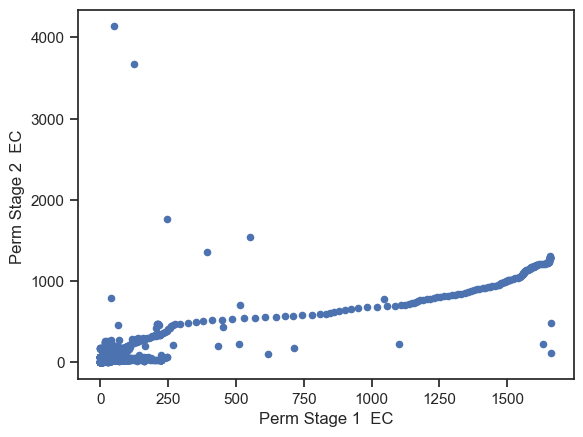

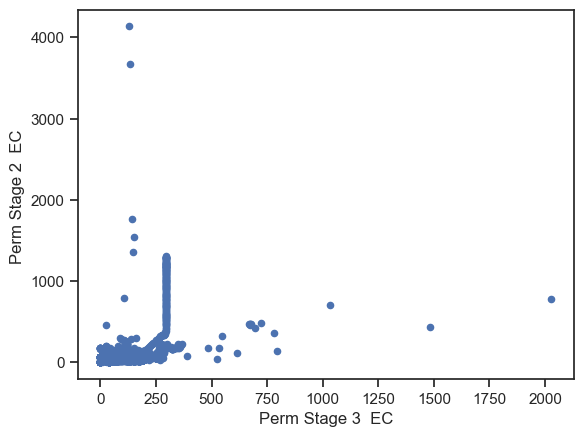

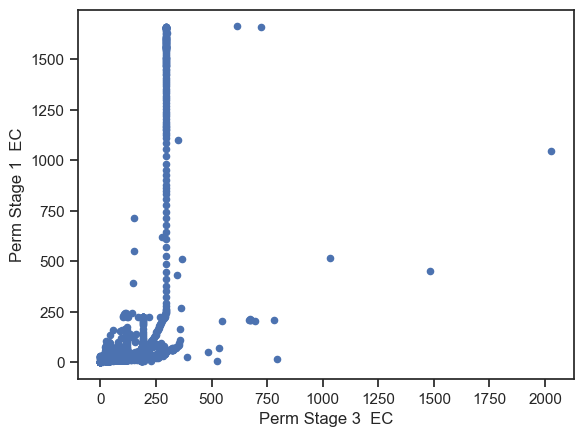

In [58]:
df_30min_dict['H02'].plot(kind='scatter',x='Perm Stage 1  EC',y='Perm Stage 2  EC ')
df_30min_dict['H02'].plot(kind='scatter',x='Perm Stage 3  EC',y='Perm Stage 2  EC ')
df_30min_dict['H02'].plot(kind='scatter',x='Perm Stage 3  EC',y='Perm Stage 1  EC')

## clean data based on Kyle inputs on 30-min raw df

In [6]:
cleaned_df_dict ={}
for k in df_30min_dict.keys():
    cleaned_df_dict[k] = drop_columns_with_high_missing_percentages(df_30min_dict[k], 50)
    cleaned_df_dict[k]= pd.DataFrame(cleaned_df_dict[k].drop(columns=['level_1']) )
    #cleaned_df_dict[k+"cleaned"] = cleaned_df_dict[k+"cleaned"].set_index('Timestamp')

In [11]:
cleaned_df_dict.keys()

dict_keys(['FEED', 'ROF', 'C02', 'E01', 'H02'])

In [7]:
#replace erroneous values with nan before taking daily/weekly aggregate--create meta data file later for all vars
cleaned_df_dict['ROF'].loc[cleaned_df_dict['ROF']['EC'] > 4000, 'EC'] = np.nan
cleaned_df_dict['ROF'].loc[cleaned_df_dict['ROF']['pH'] <6.4, 'pH'] = np.nan
cleaned_df_dict['C02'].loc[cleaned_df_dict['C02']['Concentrate  EC'] <5000, 'Concentrate  EC'] = np.nan #drop super values
cleaned_df_dict['C02'] = cleaned_df_dict['C02'].drop(columns=['Stage 1 %removal','Stage 2  %removal', 'Stage 3 %removal','Unit AFBC %removal']) #calculate these later; drop raw values for now
cleaned_df_dict['E01'] = cleaned_df_dict['E01'].drop(columns=['Stage 1 %removal','Stage 2  %removal','Stage 3 %removal','Unit AFBC %removal']) #calculate these later; drop raw values for now
cleaned_df_dict['H02'].loc[cleaned_df_dict['H02']['Concentrate  EC'] >20000, 'Concentrate  EC'] = np.nan #drop super high values


In [8]:
for k in cleaned_df_dict.keys():
    #new_columns = [k + '_' + col for col in cleaned_df_dict.columns]
    cleaned_df_dict[k].columns = [k + '_' + '_'.join(col.strip().split()).replace('cleaned', '') for col in cleaned_df_dict[k].columns]
cleaned_df_dict[k].columns

Index(['H02_Concentrate_EC', 'H02_Stage_1-2_EC', 'H02_Stage_2-3_EC',
       'H02_Perm_Stage_1_EC', 'H02_Perm_Stage_2_EC', 'H02_Perm_Stage_3_EC',
       'H02_Stage_1_%removal', 'H02_Stage_2_%removal', 'H02_Stage_3_%removal',
       'H02_Unit_AFBC_%removal', 'H02_Permeate_flow', 'H02_Concentrate_flow',
       'H02_Stage_2_Perm_flow', 'H02_Stage_3_Perm_flow'],
      dtype='object')

In [9]:
cleaned_df = pd.concat([cleaned_df_dict['FEED'], cleaned_df_dict['ROF'], cleaned_df_dict['C02'], 
cleaned_df_dict['E01'], cleaned_df_dict['H02']], axis=1)
cleaned_df.head(5)

FEED_NH3   FEED_NTU   ROF_NH3    ROF_EC     ROF_ROF_TOC  \
Timestamp                                                                      
2022-12-05 00:00:00  11.933330  4.203410  8.185695  1601.183960   9.509680     
2022-12-05 00:30:00  12.257180  3.937882  7.966211  1593.866943   9.525024     
2022-12-05 01:00:00  11.135010  3.779921  7.559224  1592.968018   9.563128     
2022-12-05 01:30:00   9.452497  3.485077  6.888823  1585.938965   9.630194     
2022-12-05 02:00:00   8.870444  3.192853  6.297343  1578.017944   9.560494     

                      ROF_Cl2   ROF_pH   ROF_Temp_(degF)  C02_Concentrate_EC  \
Timestamp                                                                      
2022-12-05 00:00:00  4.387215  6.899232     78.109833         9483.555664      
2022-12-05 00:30:00  4.388335  6.900168     78.097488         9495.171875      
2022-12-05 01:00:00  4.389454  6.903358     78.085136         9497.163086      
2022-12-05 01:30:00  4.390574  6.897070     78.072777         9496.127930      
2022-12-05 02:00:00  4.322785  6.898346     78.060440         9492.833008      

                     C02_Stage_1-2_EC  C02_Stage_2-3_EC  C02_Perm_Stage_1_EC  \
Timestamp                                                                      
2022-12-05 00:00:00        NaN               NaN              91.427879        
2022-12-05 00:30:00        NaN               NaN              91.938263        
2022-12-05 01:00:00        NaN               NaN              92.448631        
2022-12-05 01:30:00        NaN               NaN              92.959007        
2022-12-05 02:00:00        NaN               NaN              93.469383        

                     C02_Perm_Stage_2_EC  C02_Perm_Stage_3_EC  \
Timestamp                                                       
2022-12-05 00:00:00       77.742973            83.295563        
2022-12-05 00:30:00       77.757660            83.945686        
2022-12-05 01:00:00       77.772339            84.693604        
2022-12-05 01:30:00       77.787018            85.447678        
2022-12-05 02:00:00       77.801712            85.942963        

                     C02_Permeate_flow  C02_Concentrate_flow  \
Timestamp                                                      
2022-12-05 00:00:00         0.0                  0.0           
2022-12-05 00:30:00         0.0                  0.0           
2022-12-05 01:00:00         0.0                  0.0           
2022-12-05 01:30:00         0.0                  0.0           
2022-12-05 02:00:00         0.0                  0.0           

                     C02_Stage_2_Perm_flow  C02_Stage_3_Perm_flow  \
Timestamp                                                           
2022-12-05 00:00:00           0.0                 0.000000          
2022-12-05 00:30:00           0.0                 0.000004          
2022-12-05 01:00:00           0.0                 0.093690          
2022-12-05 01:30:00           0.0                 0.000000          
2022-12-05 02:00:00           0.0                 0.000000          

                     E01_Concentrate_EC  E01_Stage_1-2_EC  E01_Stage_2-3_EC  \
Timestamp                                                                     
2022-12-05 00:00:00      8775.933594           NaN               NaN          
2022-12-05 00:30:00      8775.534180           NaN               NaN          
2022-12-05 01:00:00      8757.025391           NaN               NaN          
2022-12-05 01:30:00      8739.478516           NaN               NaN          
2022-12-05 02:00:00      8738.286133           NaN               NaN          

                     E01_Perm_Stage_1_EC  E01_Perm_Stage_2_EC  \
Timestamp                                                       
2022-12-05 00:00:00      503.569092           564.516724        
2022-12-05 00:30:00      503.464813           575.654785        
2022-12-05 01:00:00      504.637909           585.862122        
2022-12-05 01:30:00      503.830505           595.819824        
2022-

### save cleaned df

In [12]:
cleaned_df.to_csv('cleaned_30_min_data.csv')

# Specify the pickle file name
pickle_file = 'formatted_raw_30_min_data.pkl'

# Export dictionary of DataFrames as a pickle file
with open(pickle_file, 'wb') as f:
    pickle.dump(df_30min_dict, f)

## EDA with autoviz

In [ ]:
%matplotlib inline

In [ ]:
AV = AutoViz_Class()
profile_daily = AV.AutoViz('FEED.csv')

In [ ]:
AV = AutoViz_Class()
profile_daily = AV.AutoViz('ROF.csv')

In [ ]:
AV = AutoViz_Class()
profile_daily = AV.AutoViz('C02.csv')

In [ ]:
AV = AutoViz_Class()
profile_daily = AV.AutoViz('E01.csv')

In [ ]:
AV = AutoViz_Class()
profile_daily = AV.AutoViz('H02.csv')

## TS plots

In [16]:
cleaned_df_dict["FEED"].index.max().date()

datetime.date(2023, 12, 3)

<Figure size 640x480 with 0 Axes>

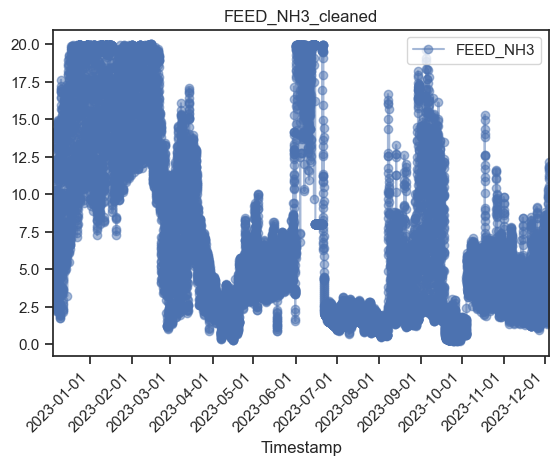

<Figure size 640x480 with 0 Axes>

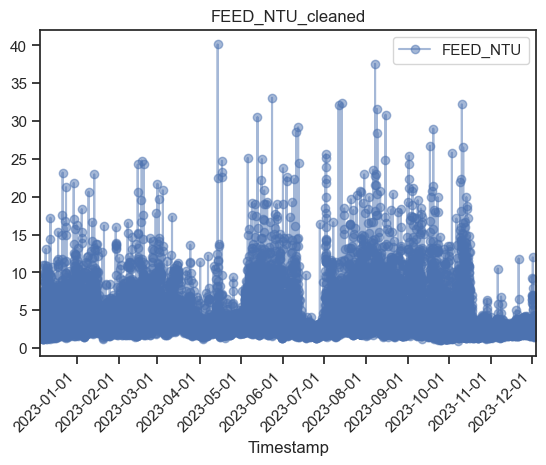

<Figure size 640x480 with 0 Axes>

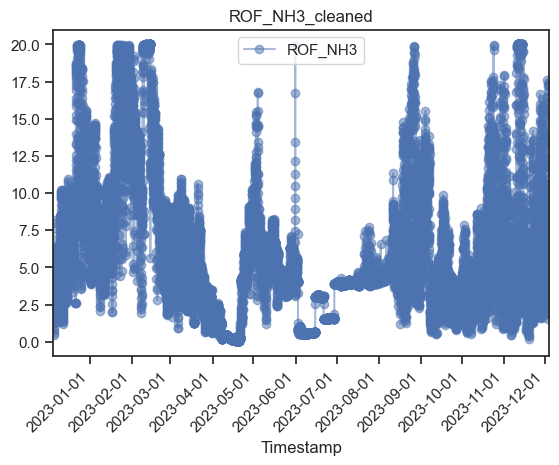

<Figure size 640x480 with 0 Axes>

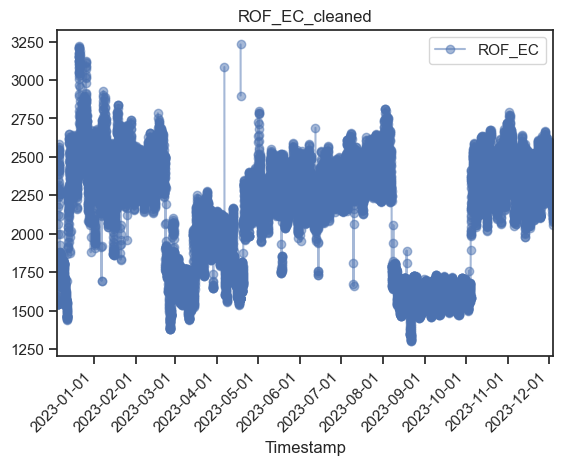

<Figure size 640x480 with 0 Axes>

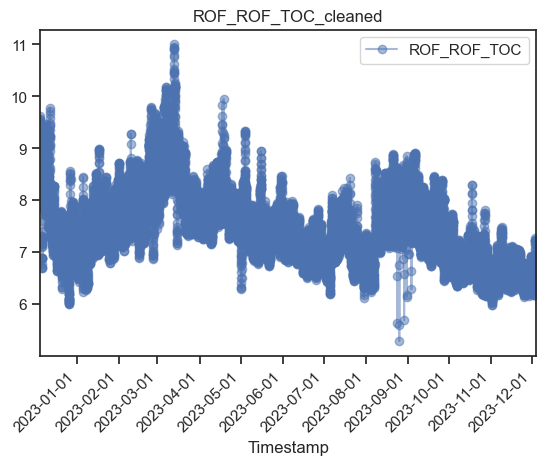

<Figure size 640x480 with 0 Axes>

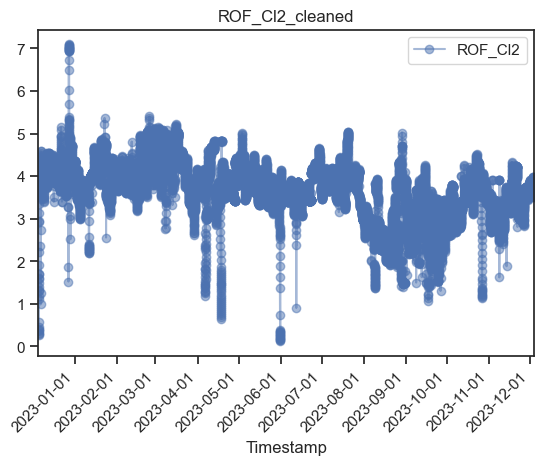

<Figure size 640x480 with 0 Axes>

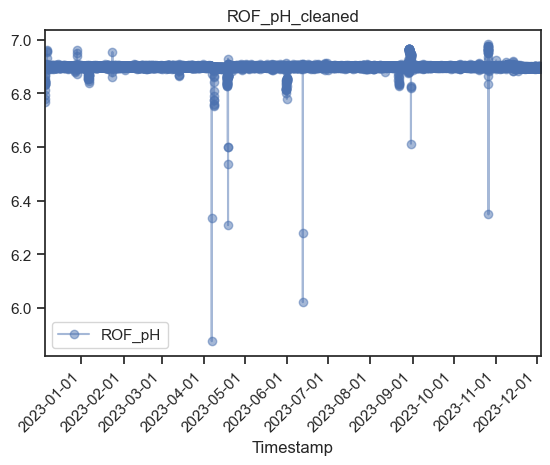

<Figure size 640x480 with 0 Axes>

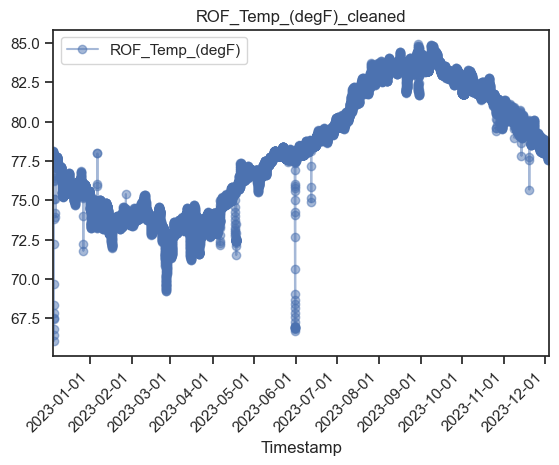

<Figure size 640x480 with 0 Axes>

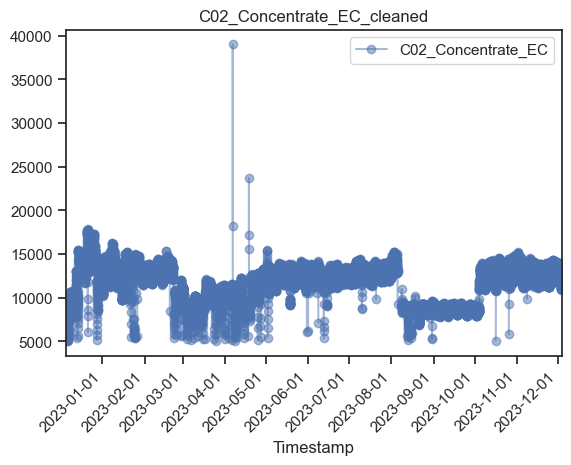

<Figure size 640x480 with 0 Axes>

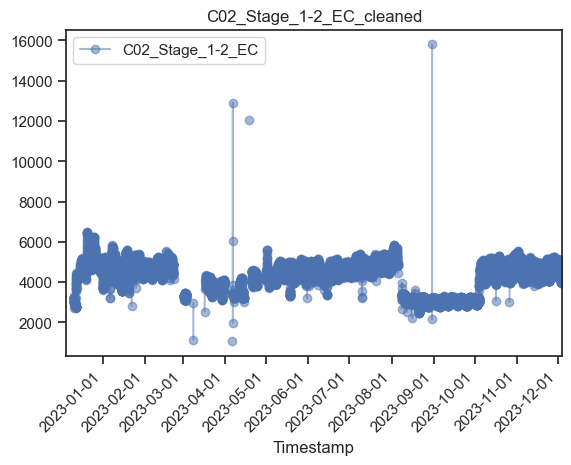

<Figure size 640x480 with 0 Axes>

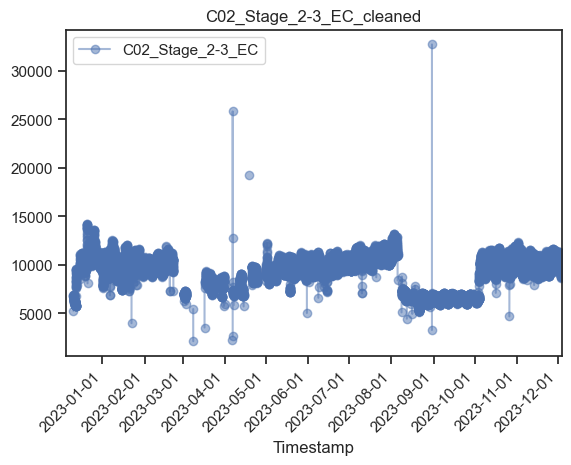

<Figure size 640x480 with 0 Axes>

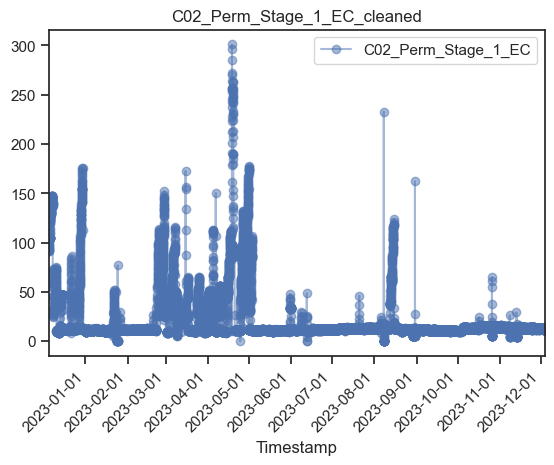

<Figure size 640x480 with 0 Axes>

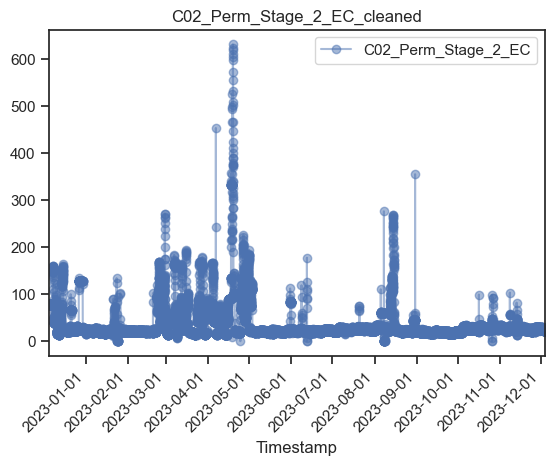

<Figure size 640x480 with 0 Axes>

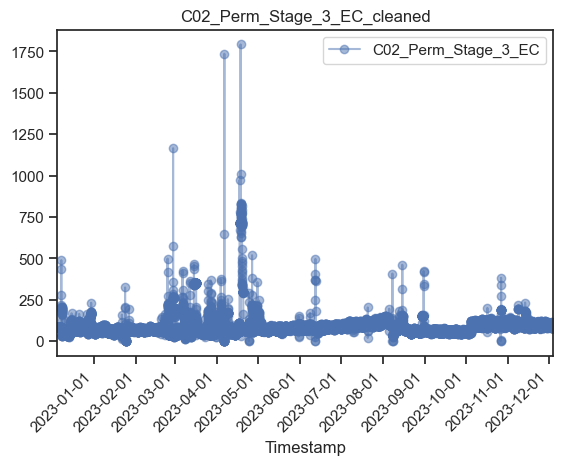

<Figure size 640x480 with 0 Axes>

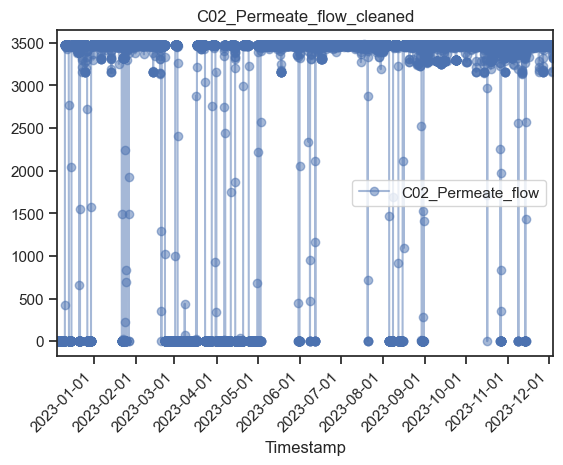

<Figure size 640x480 with 0 Axes>

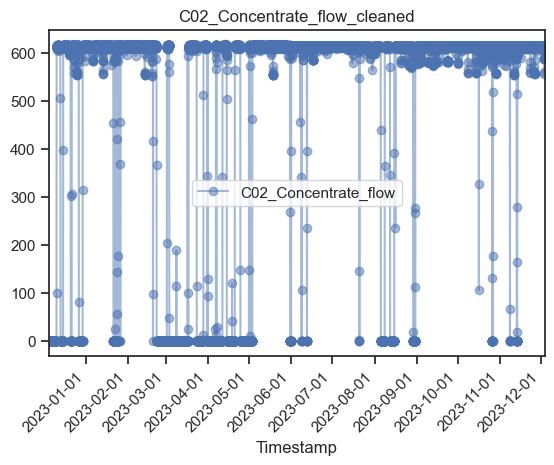

<Figure size 640x480 with 0 Axes>

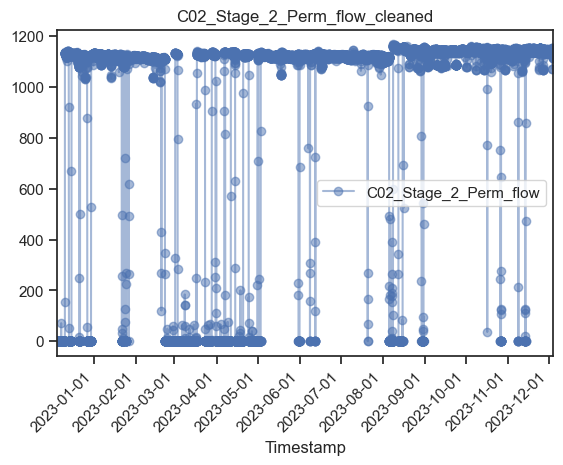

<Figure size 640x480 with 0 Axes>

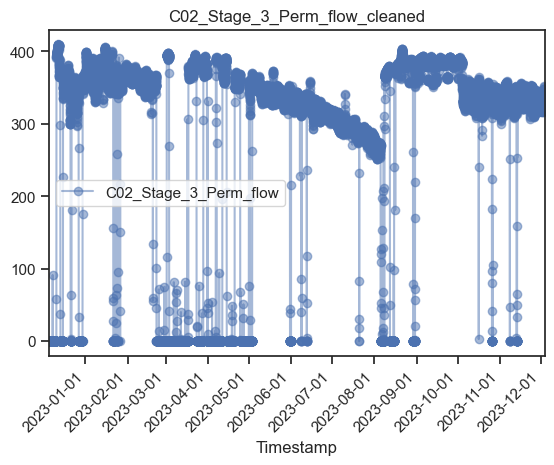

<Figure size 640x480 with 0 Axes>

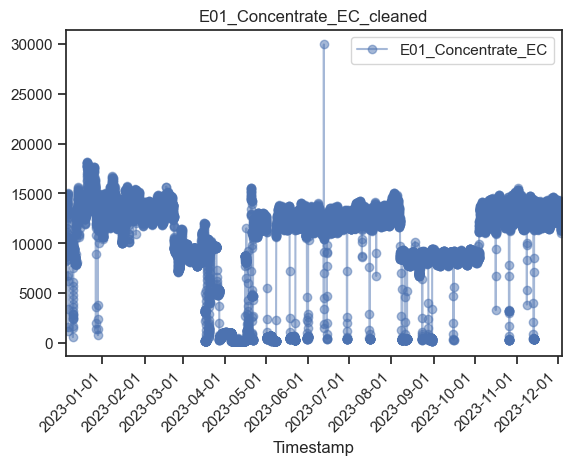

<Figure size 640x480 with 0 Axes>

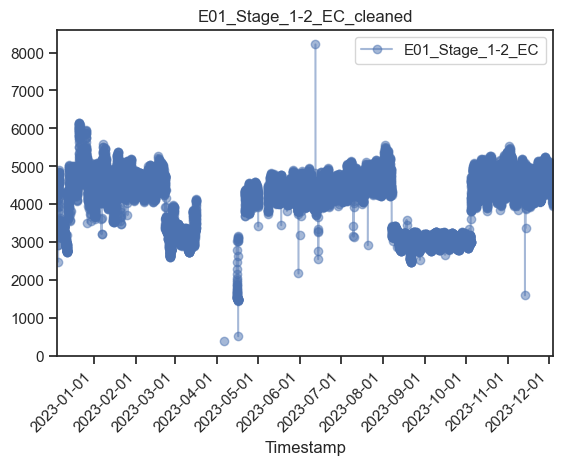

<Figure size 640x480 with 0 Axes>

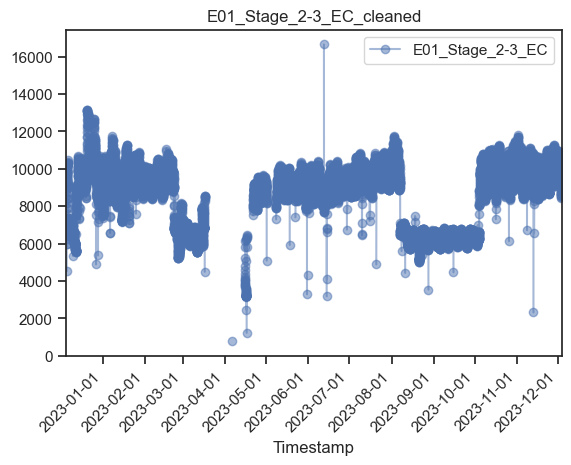

<Figure size 640x480 with 0 Axes>

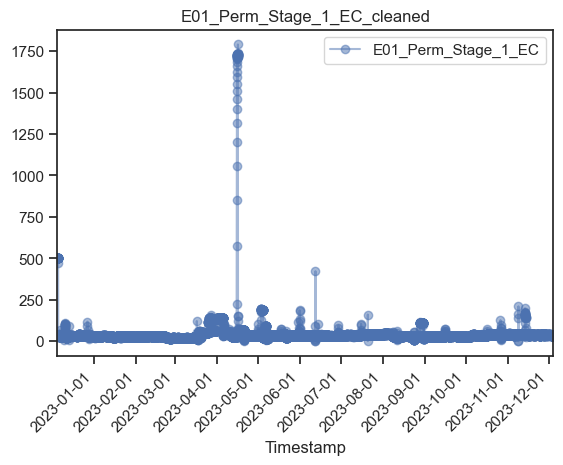

<Figure size 640x480 with 0 Axes>

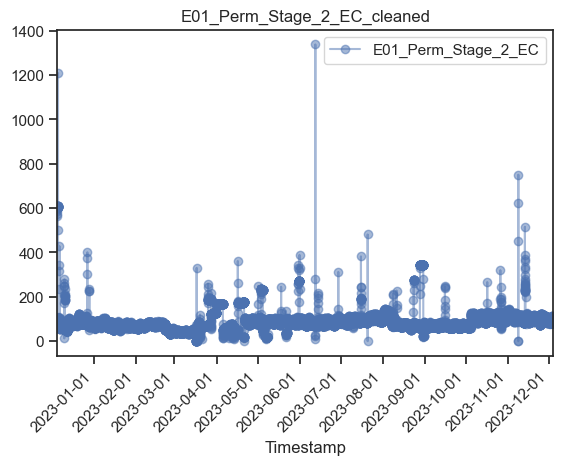

<Figure size 640x480 with 0 Axes>

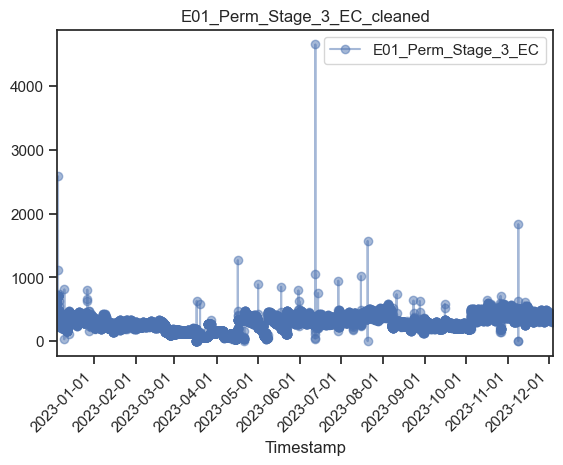

<Figure size 640x480 with 0 Axes>

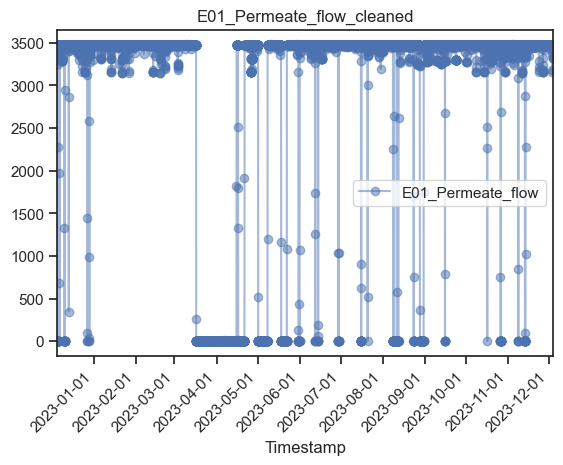

<Figure size 640x480 with 0 Axes>

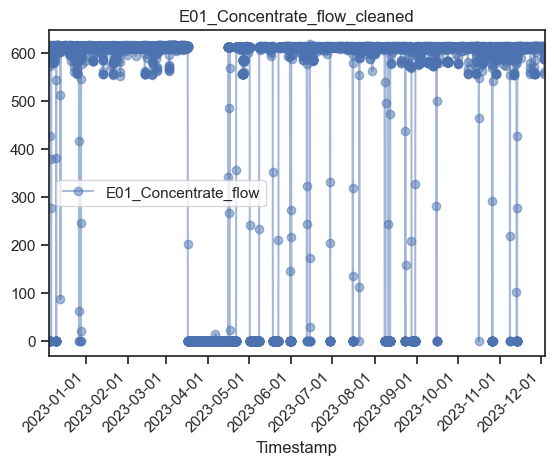

<Figure size 640x480 with 0 Axes>

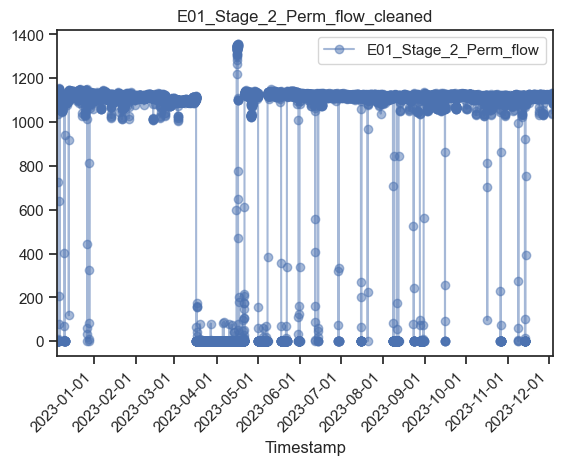

<Figure size 640x480 with 0 Axes>

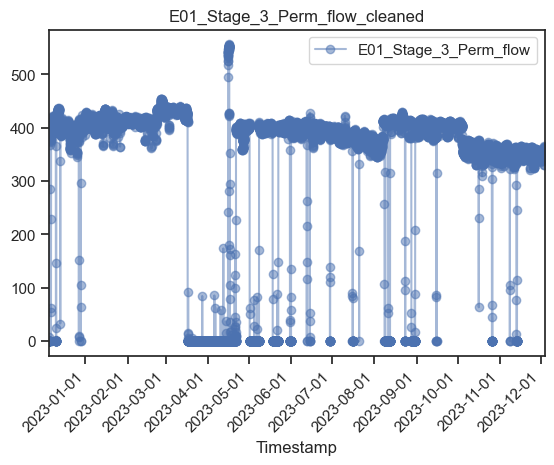

<Figure size 640x480 with 0 Axes>

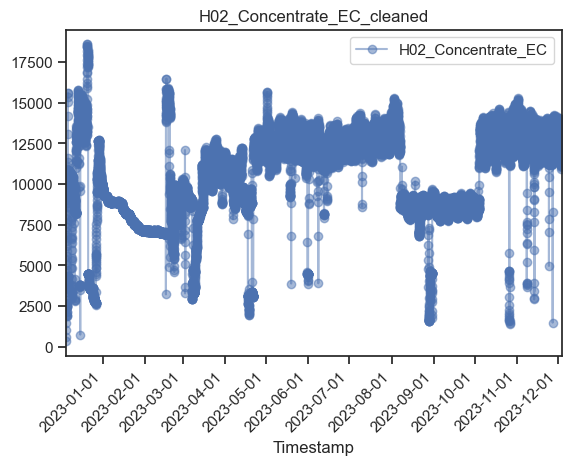

<Figure size 640x480 with 0 Axes>

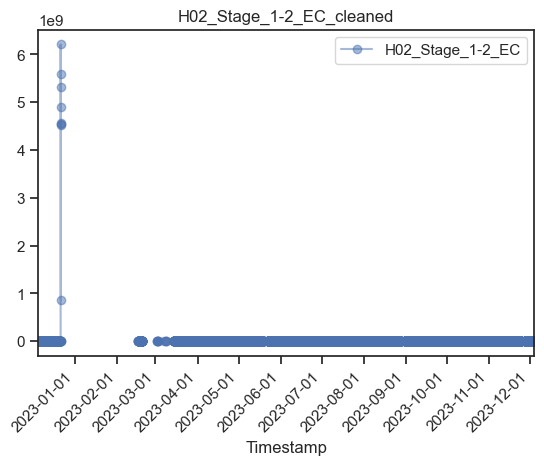

<Figure size 640x480 with 0 Axes>

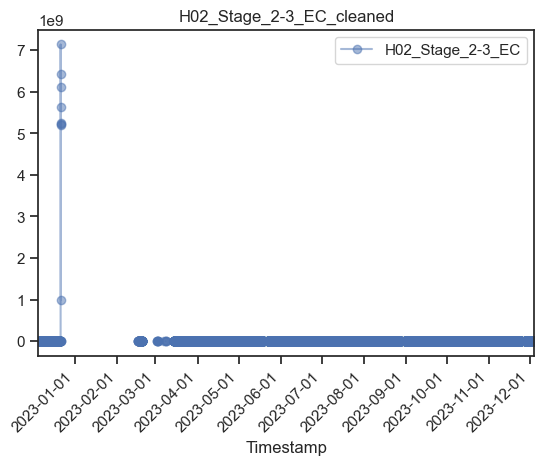

<Figure size 640x480 with 0 Axes>

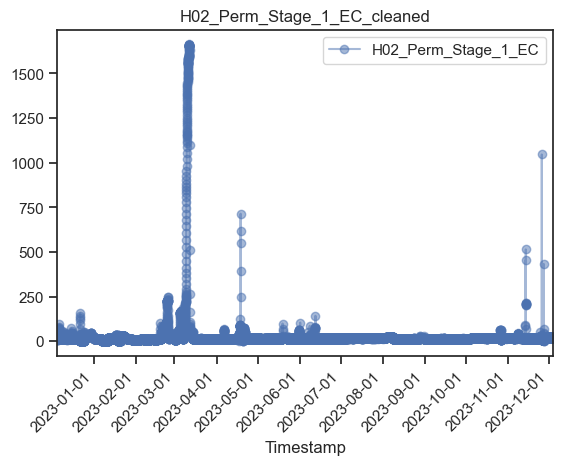

<Figure size 640x480 with 0 Axes>

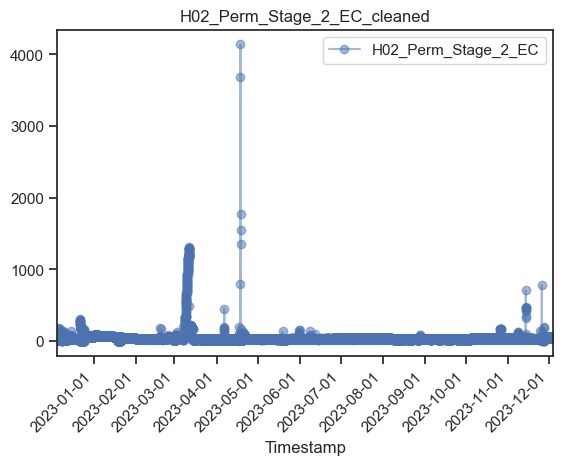

<Figure size 640x480 with 0 Axes>

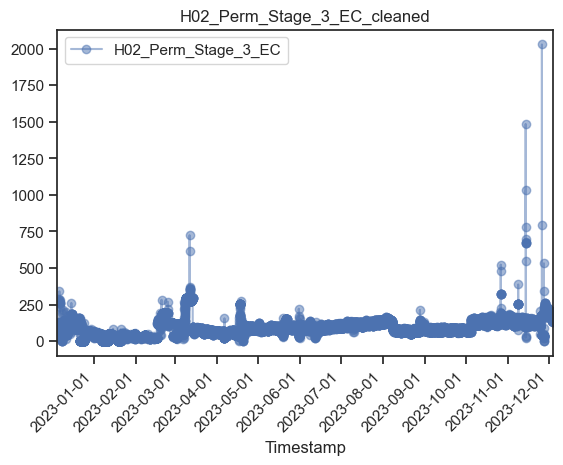

<Figure size 640x480 with 0 Axes>

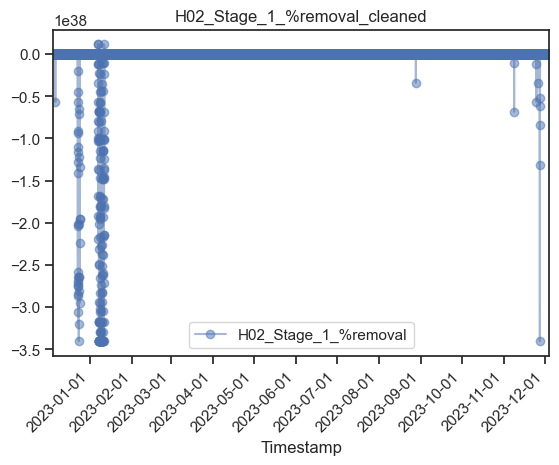

<Figure size 640x480 with 0 Axes>

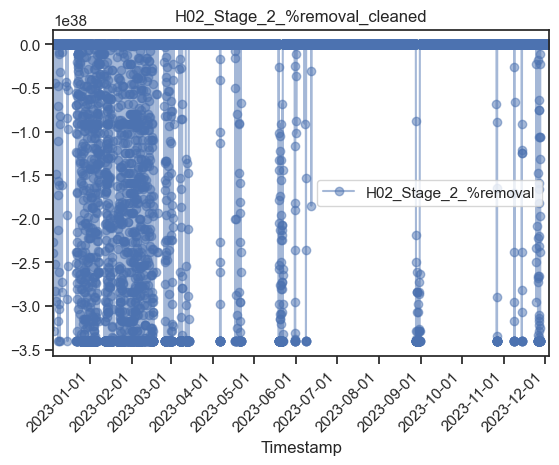

<Figure size 640x480 with 0 Axes>

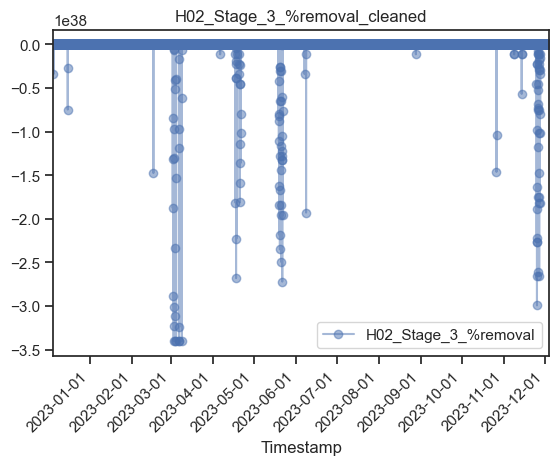

<Figure size 640x480 with 0 Axes>

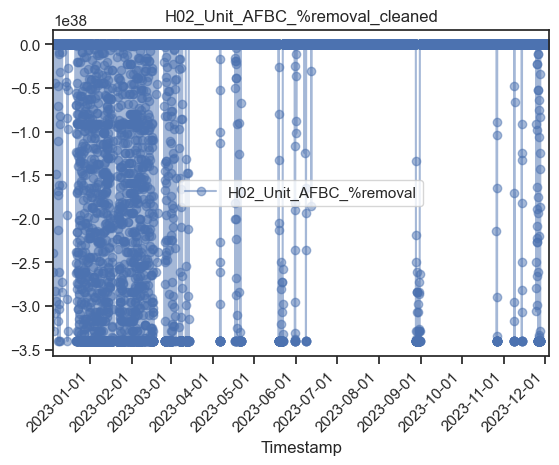

<Figure size 640x480 with 0 Axes>

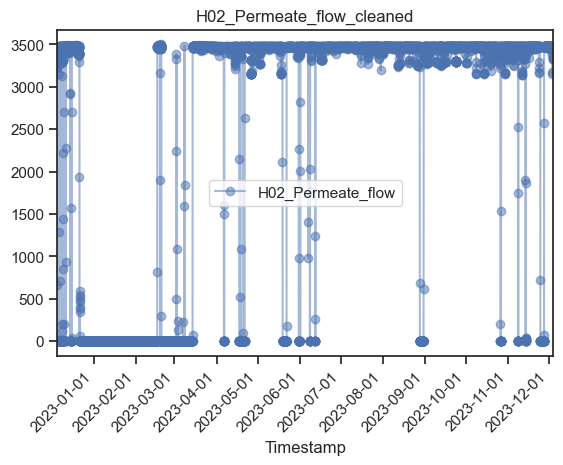

<Figure size 640x480 with 0 Axes>

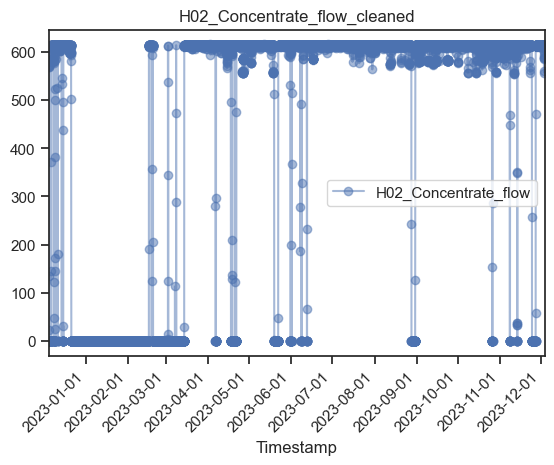

<Figure size 640x480 with 0 Axes>

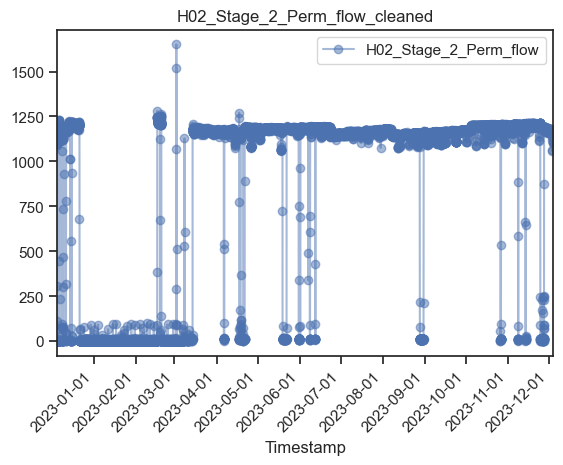

<Figure size 640x480 with 0 Axes>

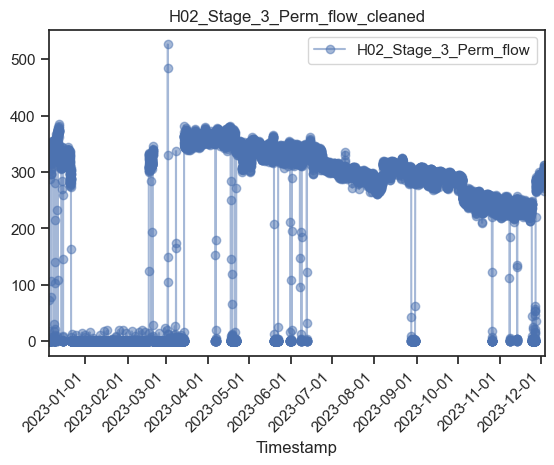

In [103]:
# plot 30-min raw data
plot_dict={}
# Create a PDF file object
pdf_pages = PdfPages('30min_WQ_yearly_plots_no_comments.pdf')

for x in cleaned_df.columns:
    fig = plt.figure()
    try:
        fig = cleaned_df[[x]].plot(marker='o',alpha=0.5) 
        fig.set_title(label=x+"_cleaned")
        
        plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        plt.xlim(cleaned_df[[x]].index.min(), cleaned_df[[x]].index.max())
    except TypeError as e:
        print("error:",e)
    # Save the current figure to the PDF
    pdf_pages.savefig()
    plot_dict[x] = fig.get_figure()
# Close the PDF file object
pdf_pages.close()

In [118]:
#plot dailyly avg
plot_dict_daily={}
# Resample DataFrame to weekly averages
daily_avg_df = cleaned_df.resample('D').mean()  # 'W' denotes weekly resampling
    
# Assuming cleaned_df_dict is your dictionary of DataFrames
# Create a PDF file object
pdf_pages = PdfPages('daily_average_WQ_plots.pdf')
# Iterate over each column in the resampled DataFrame
for x in daily_avg_df.columns:
    fig = plt.figure()
    try:
        # Plot
        plt.figure(figsize=(8, 4)) 
        daily_avg_df[[x]].plot(ax=plt.gca() )  # Use ax=plt.gca() to plot on the current axis, ax=plt.gca()
        plt.title(k + ":" + x)  # Set plot title
        # plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
        # #plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
        # plt.xlim(cleaned_df[[x]].index.min(), cleaned_df[[x]].index.max())
        plt.ylabel('Value')  # Set y-axis label
        # set monthly locator
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        plt.minorticks_off()
    except TypeError as e:
        print("Error:", e)
    
    # Save the current figure to the PDF
    pdf_pages.savefig()
    
    # Store the figure object in plot_dict if needed
    plot_dict_daily[x] = fig
    
# Close the figure for the current key
plt.close('all')

# Close the PDF file object
pdf_pages.close()

In [119]:
#plot weekly avg
plot_dict_weekly={}

# Resample DataFrame to weekly averages
weekly_avg_df = cleaned_df.resample('W').mean()  # 'W' denotes weekly resampling
# Create a PDF file object
pdf_pages = PdfPages('weekly_average_WQ_plots.pdf')
# Iterate over each column in the resampled DataFrame
for x in weekly_avg_df.columns:
    fig = plt.figure()
    try:
        # Plot the weekly average data
        weekly_avg_df[[x]].plot(ax=plt.gca())  # Use ax=plt.gca() to plot on the current axis
        plt.title(k + ":" + x)  # Set plot title        
        plt.ylabel('Value')  # Set y-axis label
         # set monthly locator
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        plt.minorticks_off()
    except TypeError as e:
        print("Error:", e)
    
    # Save the current figure to the PDF
    pdf_pages.savefig()
    
    # Store the figure object in plot_dict if needed
    plot_dict_weekly[x] = fig
    
# Close the figure for the current key
plt.close('all')

# Close the PDF file object
pdf_pages.close()



## Distribution plots

In [ ]:
from bokeh.plotting import output_file, save

In [ ]:
plots = []
# Create a PDF file object
pdf_pages = PdfPages('30min_WQ_distribution_plots.pdf')
for k in cleaned_df_dict.keys():
    Temp = pd.DataFrame(cleaned_df_dict[k])#.reset_index()
    for c in Temp.columns:
        print(k, ":",c)
        temp=Temp[[c]]
        #source = ColumnDataSource(temp[[c]])
        try:
            # # Create box plot
            # p1 = figure(title=f"{k}: {c}", x_axis_label=c, y_axis_label="Value")
            # p1.vbar(x=c , top=temp[c].max(), bottom=temp[c].min(), source=source, width=0.5, color="skyblue")
            
            # Create histogram
            plt.figure(figsize=(8, 6))
            temp[c].plot.hist(bins=15, color='orange', edgecolor='black')
            plt.title(label=k)
            plt.xlabel(x)
            # p2 = figure(title=f"{k}: {c}", x_axis_label=c, y_axis_label="Frequency")
            # p2.quad(top=temp[c].value_counts().values, bottom=0, left=temp[c].value_counts().index - 0.5,
            #          right=temp[c].value_counts().index + 0.5, color="orange")
            
            # plots.append([ p2])
        except TypeError as e:
            print("error:", e, k, c)

# Arrange plots in a grid layout
#layout = gridplot(plots)

# Show the grid layout
#show(layout)
# Specify the output file (PDF)
#output_file("30min_WQ_histogram_plots.html")

# Save the grid layout
#save(layout)
pdf_pages.close()

In [ ]:
#plot_dict={key: {} for key in cleaned_df_dict.keys()}
# Create a PDF file object
#pdf_pages = PdfPages('30min_WQ_distribution_plots.pdf')
for k in cleaned_df_dict.keys():
    
    for x in cleaned_df_dict[k].columns:
        Temp=cleaned_df_dict[k][[x]]
        try:
            #fig = cleaned_df_dict[k][[x]].plot() 
            
            plt.figure(figsize=(11, 5))
            plt.subplot(1, 2, 1)
            sns.boxplot(x=x, data=Temp)
            plt.title(label=k)
            plt.xlabel(x)
            plt.subplot(1, 2, 2)
            plt.hist(Temp[x], bins=15)
            plt.title(label=k+":"+x)
            plt.xlabel(x)
            plt.show()
        except TypeError as e:
            print("error:",e)
        #Save the current figure to the PDF
        #pdf_pages.savefig(plt.gcf())
       #plot_dict[k][x] = fig.get_figure()
# Close the PDF file object
#pdf_pages.close()

In [ ]:
Temp
#fig = cleaned_df_dict[k][[x]].plot() 
            
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x=x, data=Temp)
plt.title(label=k+":"+x)
plt.xlabel(x)
plt.subplot(1, 2, 2)
plt.hist(Temp[x], bins=15)
plt.title(label=k+":"+x)
plt.xlabel(x)

# Explore daily operational data

In [44]:
df_C02_daily = pd.read_excel('data_package_2022_2023/RO_Data_A_E_OCWD_SPI.xlsx',sheet_name="RO C02-Report", index_col='date')
df_E01_daily = pd.read_excel('data_package_2022_2023/RO_Data_A_E_OCWD_SPI.xlsx',sheet_name="RO E01-Report", index_col='date')
df_H02_daily = pd.read_excel('data_package_2022_2023/RO_Data_F-I-OCWD - PCS_shared_to_MFS_team.xlsx',sheet_name="RO H02-Report",index_col='date')

In [22]:
df_C02_daily.dtypes

Feed psi                                float64
Conc Press Stage 1                      float64
Feed Press Stage 2                      float64
Stage 2-3 Press                         float64
Conc psi                                float64
Perm Press Stage 1                      float64
Perm psi                                float64
Perm Flow                               float64
Stage 2 Perm Flow                       float64
Stage 3  Perm Flow                      float64
Conc flow                               float64
Perm EC                                 float64
Perm EC Stage 1                         float64
Perm EC Stage 2                         float64
Perm EC Stage 3                         float64
Conc EC                                 float64
kWh Feed Pump                           float64
ERD/IBP          kW                     float64
Unnamed: 19                             float64
Temp (C.)                               float64
TCF Water                               

In [23]:
df_C02_daily.tail()

Feed psi   Conc Press Stage 1  Feed Press Stage 2  \
date                                                             
2015-01-05  222.328978      175.273705          175.273705       
2015-01-04  218.724517      173.167828          173.167828       
2015-01-03  218.164930      174.017020          174.017020       
2015-01-02  218.989944      174.086610          174.086610       
2015-01-01  218.496876      172.807016          172.807016       

            Stage 2-3 Press   Conc psi   Perm Press Stage 1  Perm psi   \
date                                                                     
2015-01-05    155.653768     115.466896       12.966030      12.966030   
2015-01-04    153.783036     115.062353       12.965872      12.965872   
2015-01-03    154.748214     116.981429       12.996538      12.996538   
2015-01-02    154.505051     117.405313       13.049836      13.049836   
2015-01-01    153.534637     117.576936       12.962401      12.962401   

             Perm Flow   Stage 2 Perm Flow  Stage 3  Perm Flow   Conc flow  \
date                                                                         
2015-01-05  3395.835052     1071.718123         299.531475      599.978826   
2015-01-04  3380.029500     1066.729925         298.137338      597.188932   
2015-01-03  3365.777503     1062.232026         296.880233      593.813798   
2015-01-02  3381.764669     1067.277541         298.290390      597.327952   
2015-01-01  3370.890818     1063.845777         297.331256      595.158587   

             Perm EC   Perm EC Stage 1  Perm EC Stage 2  Perm EC Stage 3  \
date                                                                       
2015-01-05  50.960461     32.137524        84.451374        94.191225      
2015-01-04  50.755980     32.137524        84.451374        94.191225      
2015-01-03  52.927805     32.137524        84.451374        94.191225      
2015-01-02  52.804088     32.137524        84.451374        94.191225      
2015-01-01  52.784426     32.137524        84.451374        94.191225      

              Conc EC    kWh Feed Pump  ERD/IBP          kW  Unnamed: 19  \
date                                                                       
2015-01-05  7898.991699   460.931839           NaN              NaN        
2015-01-04  7928.519023   450.558400           NaN              NaN        
2015-01-03  8130.713188   444.931800           NaN              NaN        
2015-01-02  7984.261251   450.820310           NaN              NaN        
2015-01-01  8098.819539   449.047304           NaN              NaN        

            Temp (C.)  TCF Water  Calc Perm EC   Feed Flow   \
date                                                          
2015-01-05  24.698329  1.010322     54.121141   3995.813878   
2015-01-04  24.551228  1.015402     54.121141   3977.218432   
2015-01-03  24.407472  1.020396     54.121141   3959.591301   
2015-01-02  24.334173  1.022953     54.121141   3979.092621   
2015-01-01  24.299119  1.024179     54.121141   3966.049405   

            Stage 1 Perm Flow  Stage 1-2 Feed Flow  Stage 2-3 Feed Flow  \
date                                                                      
2015-01-05     2024.585454         1971.228424          899.510301        
2015-01-04     2015.162237         1962.056195          895.326270        
2015-01-03     2006.665244         1952.926057          890.694031        
2015-01-02     2016.196739         1962.895882          895.618342        
2015-01-01     2009.713785         1956.335620          892.489843        

            1st Pass dp  2nd Pass dp  3rd Pass dp  Stage 1 Flux  Stage 2 Flux  \
date                                                                            
2015-01-05   47.055274    19.619936    39.713633     13.348915     11.482694    
2015-01-04   45.556689    19.384792    38.550956     13.286784     11.429249    
2015-01-03   44.147910    19.268805    37.639217     13.230760     11.381057    
2015-01-02   44.903334    19.581560    37.171

In [45]:
SPI_df_dict = {"C02_daily": df_C02_daily, "E01_daily": df_E01_daily, "H02_daily": df_H02_daily}
for k in SPI_df_dict.keys():
   # SPI_df_dict[k].set_index('date', inplace=True)
    SPI_df_dict[k].sort_index(inplace=True)
    SPI_df_dict[k].to_csv(k+".csv")


In [46]:
# save SPI data as pkl
# Specify the pickle file name
pickle_file = 'SPI_daily_data.pkl'

# Export dictionary of DataFrames as a pickle file
with open(pickle_file, 'wb') as f:
    pickle.dump(SPI_df_dict, f)

In [25]:
print(df_30min_dict['FEED'].index.min(), df_30min_dict['FEED'].index.max() )
#SPI_df_dict[k].iloc[SPI_df_dict[k].index.get_loc("2022-12-05"):SPI_df_dict[k].index.get_loc("2023-12-03") + 1]

2022-12-05 00:00:00 2023-12-03 23:30:00.004000


In [26]:
SPI_filtered_df = {}
for k in SPI_df_dict.keys():
    SPI_filtered_df[k+'_filt'] = SPI_df_dict[k].iloc[SPI_df_dict[k].index.get_loc("2022-12-05"):SPI_df_dict[k].index.get_loc("2023-12-03") + 1]

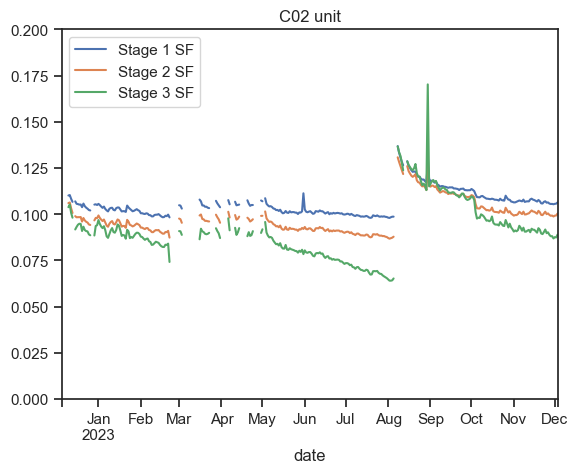

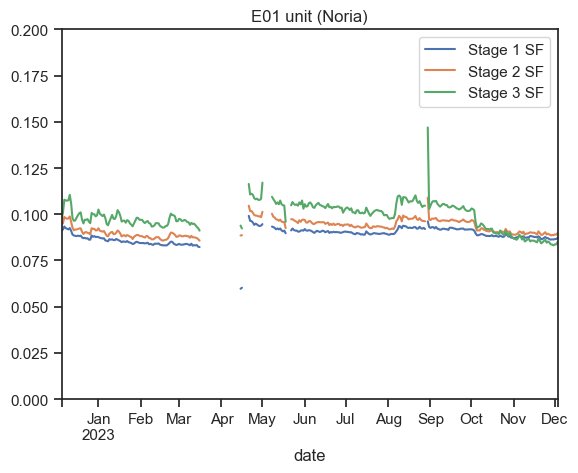

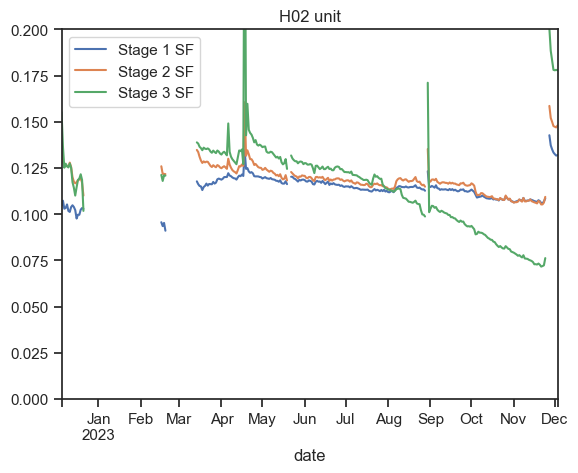

In [27]:
pdf_pages = PdfPages('daily_SF_yearly_plots.pdf')
SPI_filtered_df['C02_daily_filt'][['Stage 1 SF', 'Stage 2 SF', 'Stage 3 SF']].plot()
plt.ylim(0,0.2)
plt.title('C02 unit')
plt.minorticks_off()
pdf_pages.savefig()
SPI_filtered_df['E01_daily_filt'][['Stage 1 SF', 'Stage 2 SF', 'Stage 3 SF']].plot()
plt.ylim(0,0.2)
plt.title('E01 unit (Noria)')
plt.minorticks_off()
pdf_pages.savefig()
SPI_filtered_df['H02_daily_filt'][['Stage 1 SF', 'Stage 2 SF', 'Stage 3 SF']].plot()
plt.ylim(0,0.2)
plt.title('H02 unit')
plt.minorticks_off()
pdf_pages.savefig()
pdf_pages.close()

In [ ]:
#SPI_filtered_df[k+'_filt'] 

# Grab WQ data

In [28]:
# Read all sheets into a dictionary of DataFrames
grab_df_dict = pd.read_excel('data_package_2022_2023/Grab WQ data 2022 2023_HG.xlsx', sheet_name=None)
grab_df_dict.keys()

dict_keys(['Alkalinity (CaCO3)', 'SiO2', 'F', 'Cl', 'SO4', 'Na', 'K', 'Mg', 'Ca', 'Sr', 'Cu', 'Fe', 'PO4-P', 'Total Nitrogen', 'NO2-N', 'NO3-N'])

In [29]:
for k in grab_df_dict.keys():
    print(k)
    grab_df_dict[k]['DATETIME']=pd.to_datetime(grab_df_dict[k]['DATETIME'], errors='coerce')
    grab_df_dict[k].dropna(subset=['DATETIME'], inplace=True)
    grab_df_dict[k]['DayOfWeek']=grab_df_dict[k]['DATETIME'].dt.dayofweek
    grab_df_dict[k].set_index('DATETIME',inplace=True)
    grab_df_dict[k].sort_index(inplace=True)
    grab_df_dict[k] = grab_df_dict[k][['STATION', 'PARAMABBR','RESULT_VAL', 'UNITSABBR', 'DayOfWeek']].pivot_table(index=grab_df_dict[k].index, columns=['STATION','UNITSABBR'], values='RESULT_VAL', aggfunc='sum')
    grab_df_dict[k].columns =grab_df_dict[k].columns.map(lambda x: f'_{k}_'.join(x))

Alkalinity (CaCO3)
SiO2
F
Cl
SO4
Na
K
Mg
Ca
Sr
Cu
Fe
PO4-P
Total Nitrogen
NO2-N
NO3-N


In [41]:
# save as pkl

# Specify the pickle file name
pickle_file = 'formatted_grab_WQ_data.pkl'

# Export dictionary of DataFrames as a pickle file
with open(pickle_file, 'wb') as f:
    pickle.dump(grab_df_dict, f)

## graph to see distribution

In [34]:
Temp

GWRS-ROF_Alkalinity (CaCO3)_mg/L  \
DATETIME                                                
2022-12-14 06:00:00                209.0                
2023-01-11 06:00:00                204.0                
2023-02-08 06:00:00                232.0                
2023-03-08 06:00:00                207.0                
2023-04-05 06:00:00                214.0                
2023-05-10 06:00:00                214.0                
2023-06-07 06:00:00                204.0                
2023-07-12 06:00:00                208.0                
2023-08-09 06:00:00                185.0                
2023-09-13 06:00:00                177.0                
2023-10-04 06:00:00                173.0                
2023-11-08 06:00:00                191.0                

                     GWRS-ROP_Alkalinity (CaCO3)_mg/L  
DATETIME                                               
2022-12-14 06:00:00                10.8                
2023-01-11 06:00:00                 8.3                
2023-02-08 06:00:00                10.5                
2023-03-08 06:00:00                 7.3                
2023-04-05 06:00:00                 7.3                
2023-05-10 06:00:00                 9.4                
2023-06-07 06:00:00                 9.5                
2023-07-12 06:00:00                12.1                
2023-08-09 06:00:00                 8.9                
2023-09-13 06:00:00                 7.2                
2023-10-04 06:00:00                 7.5                
2023-11-08 06:00:00                 9.6

error: no numeric data to plot


Exception ignored in: <function ZipFile.__del__ at 0x0000022B11978790>
Traceback (most recent call last):
  File "c:\Users\YKoyama\.conda\envs\py39\lib\zipfile.py", line 1816, in __del__
    self.close()
  File "c:\Users\YKoyama\.conda\envs\py39\lib\zipfile.py", line 1833, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


<Figure size 640x480 with 0 Axes>

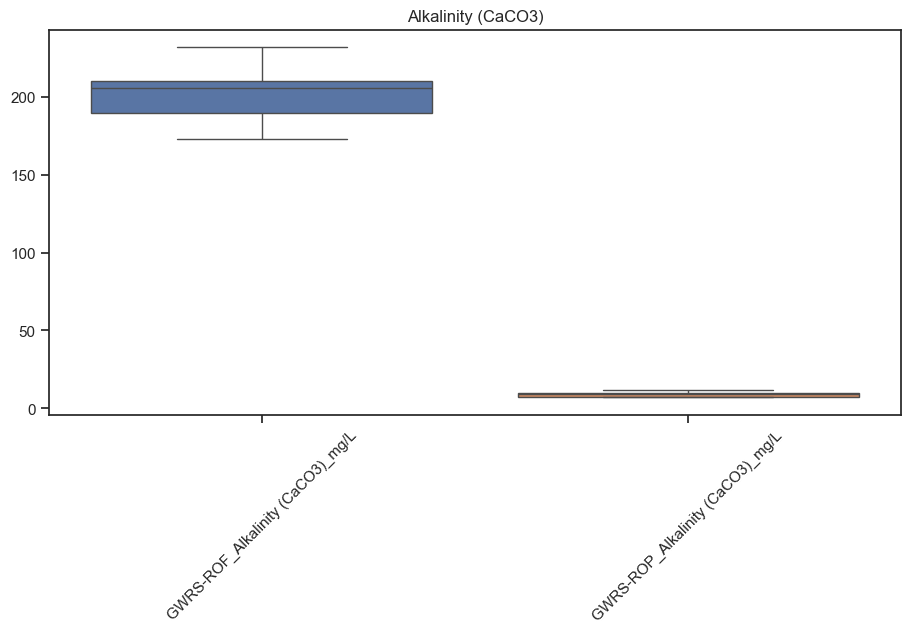

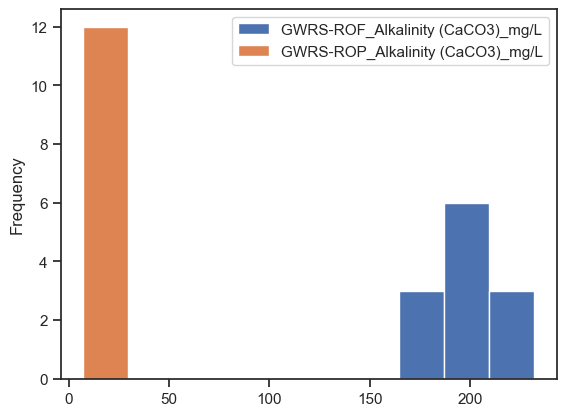

<Figure size 640x480 with 0 Axes>

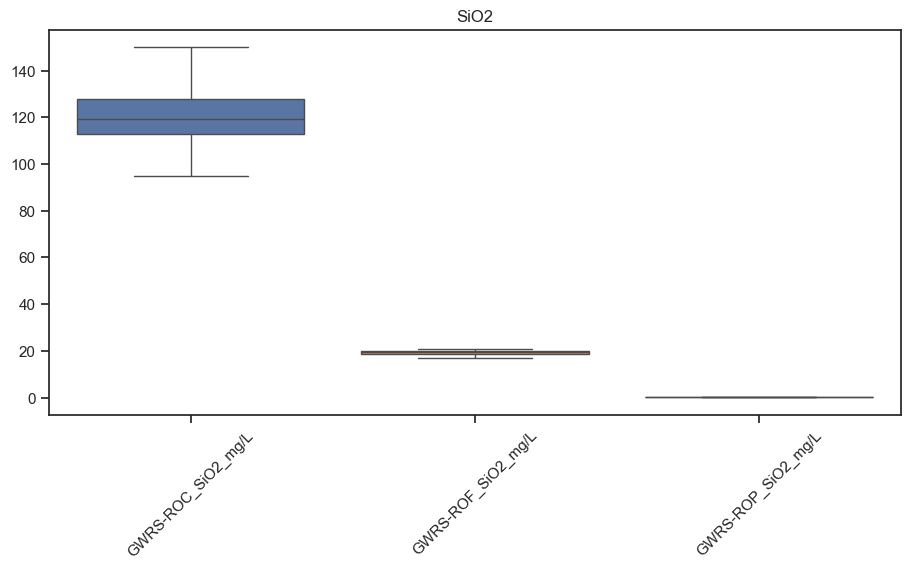

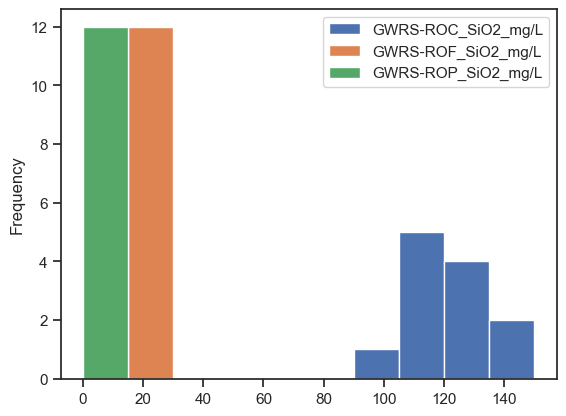

<Figure size 640x480 with 0 Axes>

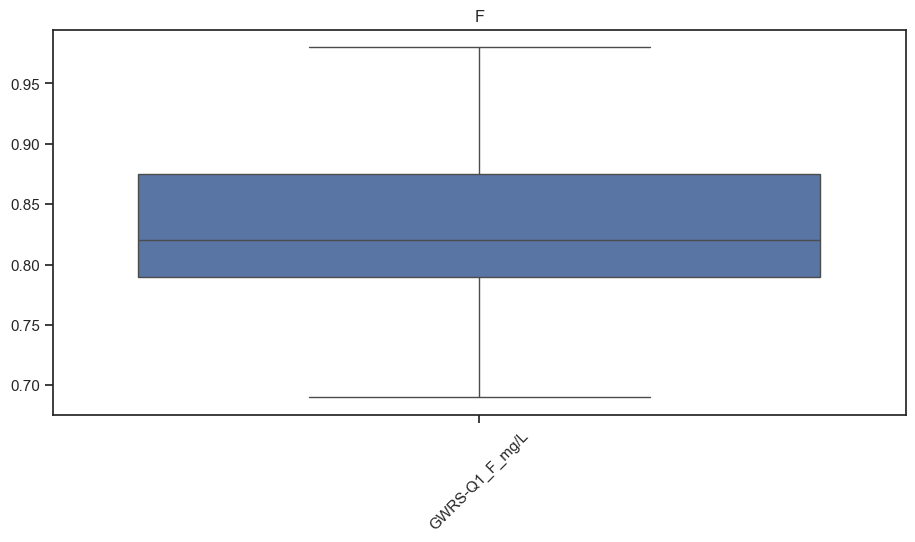

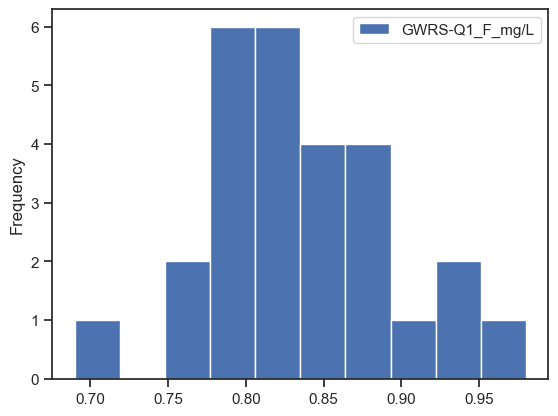

<Figure size 640x480 with 0 Axes>

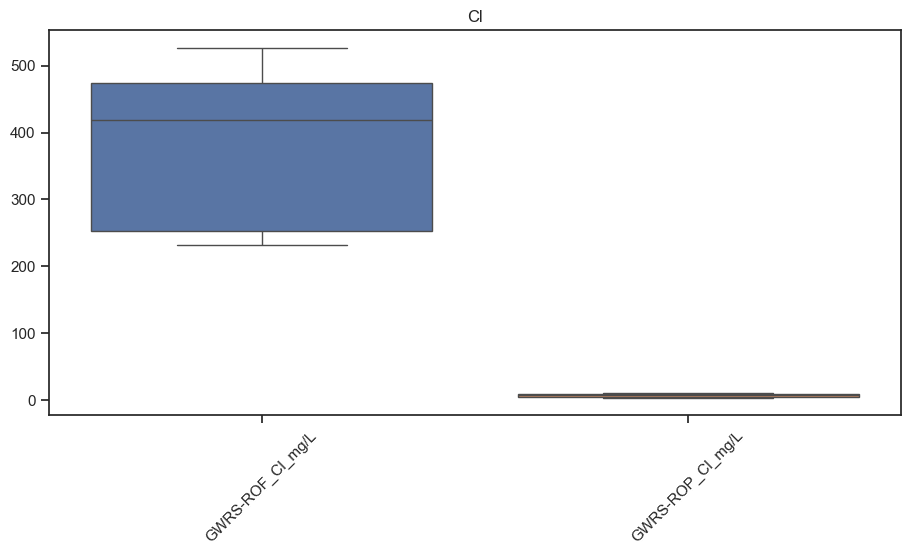

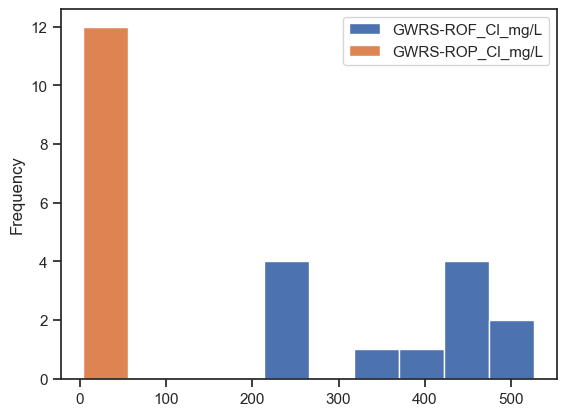

<Figure size 640x480 with 0 Axes>

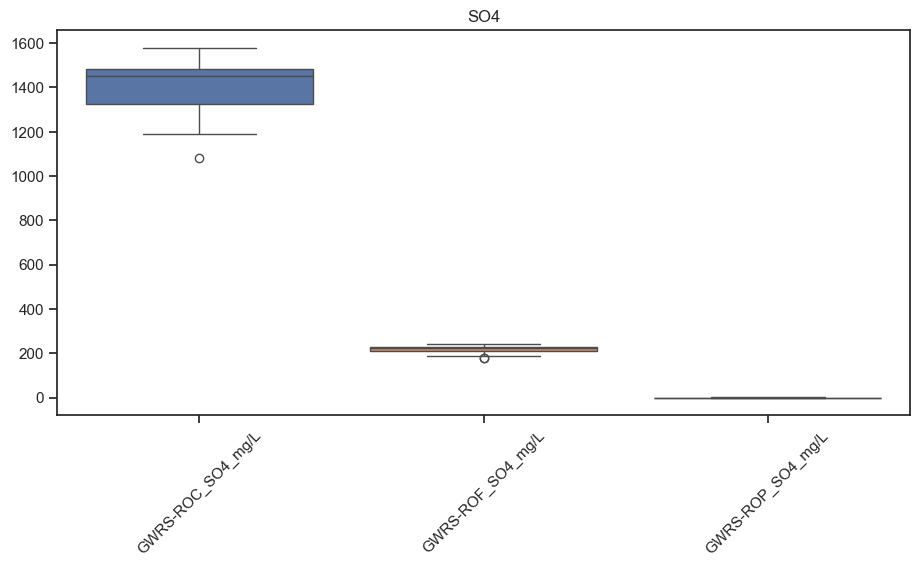

<Figure size 640x480 with 0 Axes>

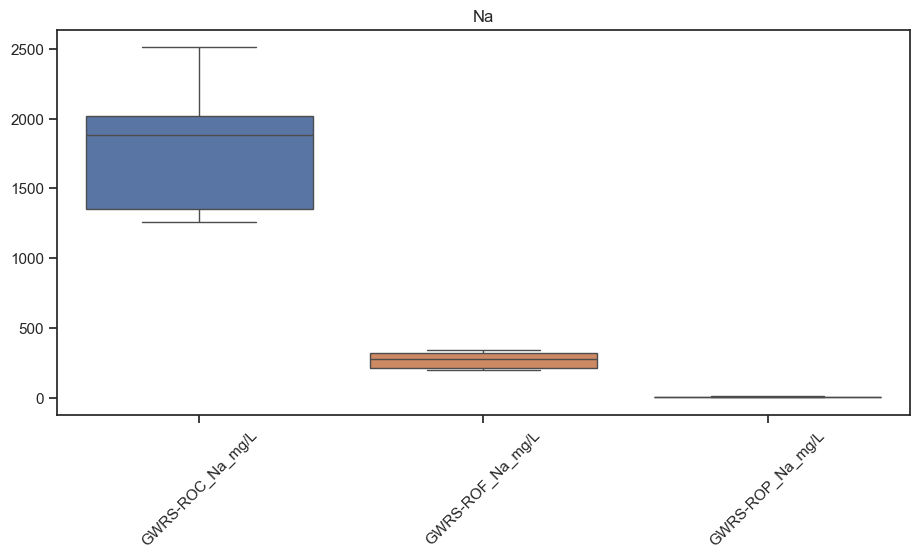

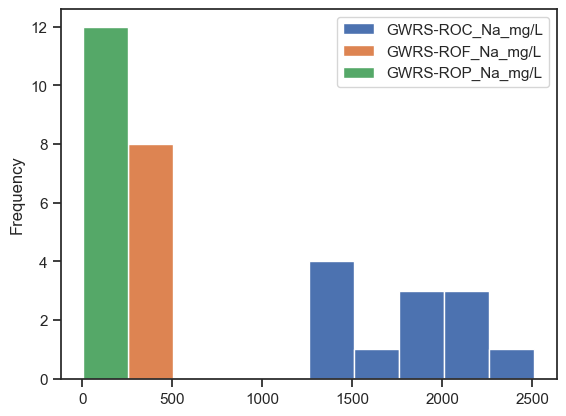

<Figure size 640x480 with 0 Axes>

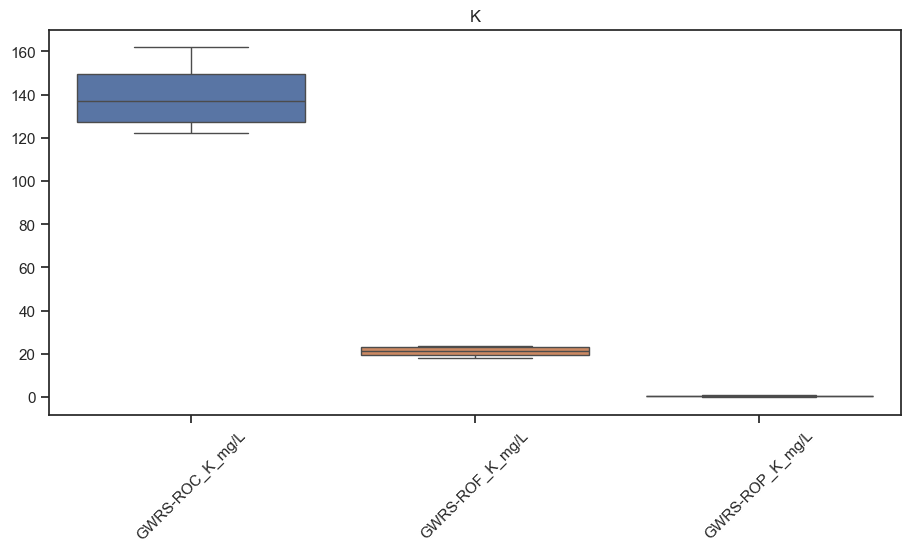

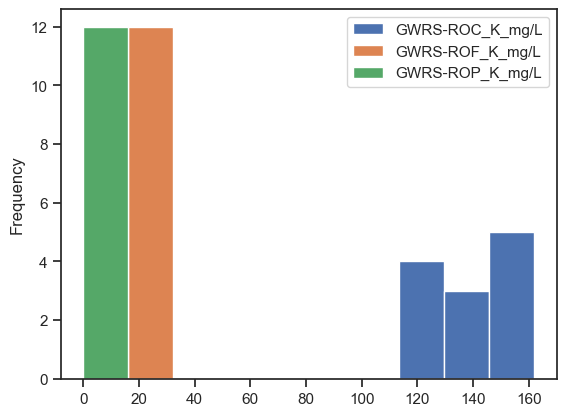

<Figure size 640x480 with 0 Axes>

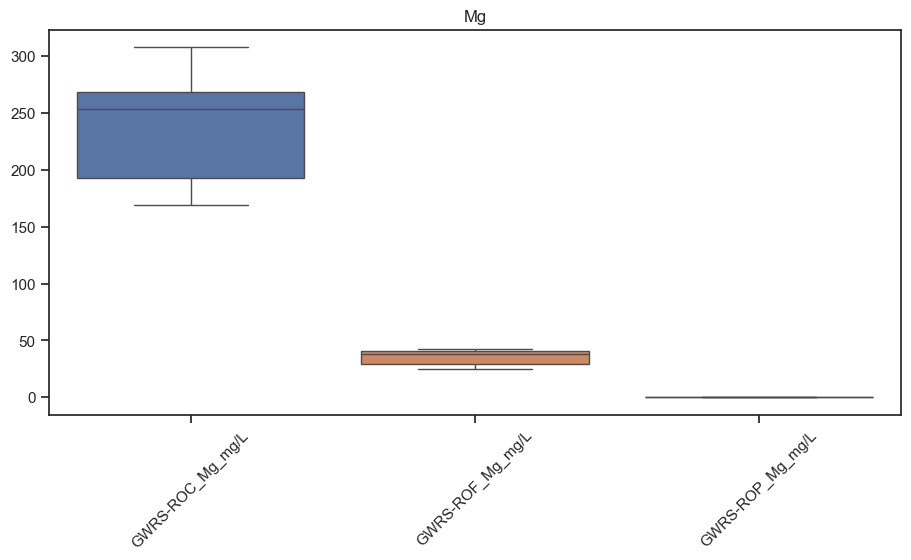

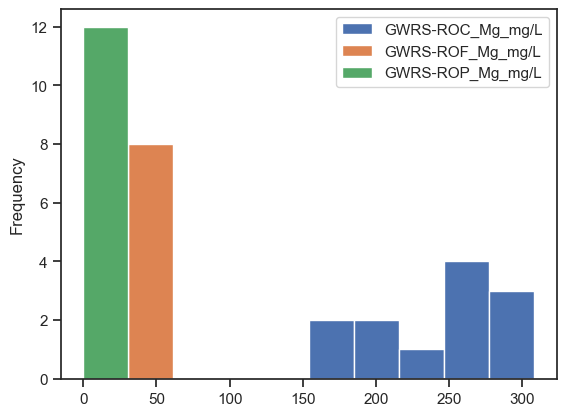

<Figure size 640x480 with 0 Axes>

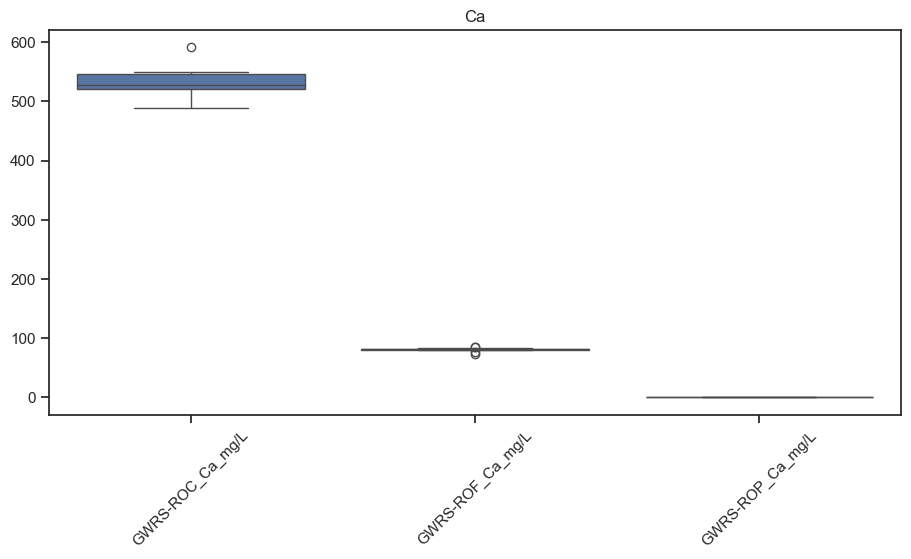

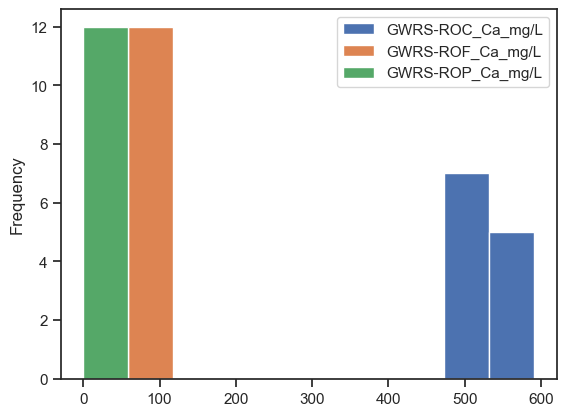

<Figure size 640x480 with 0 Axes>

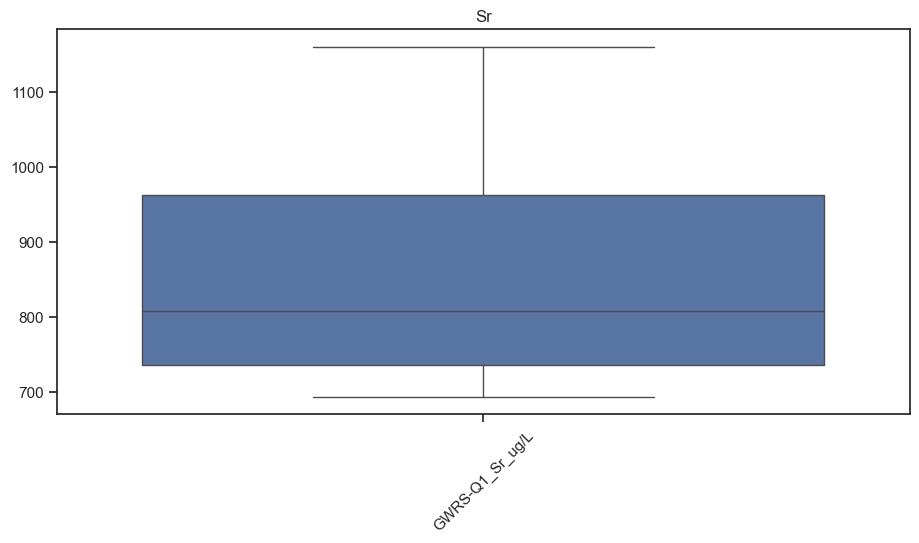

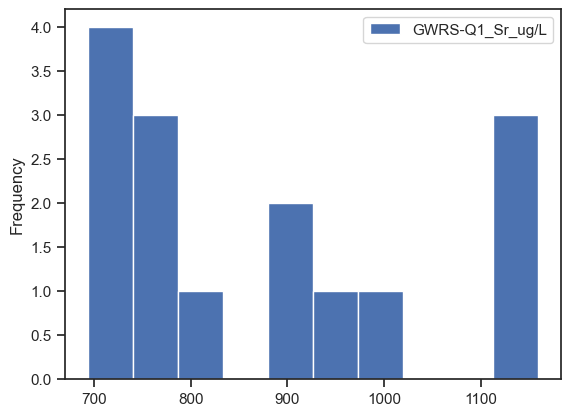

<Figure size 640x480 with 0 Axes>

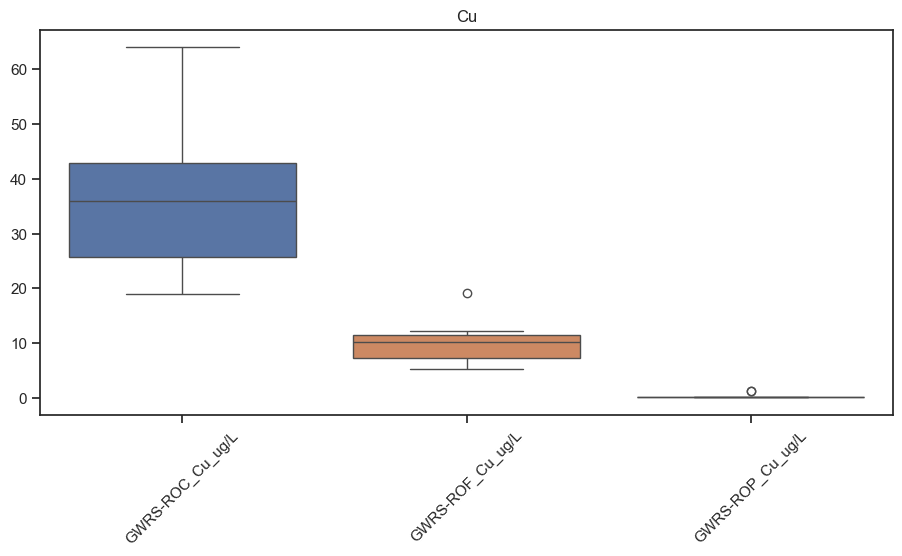

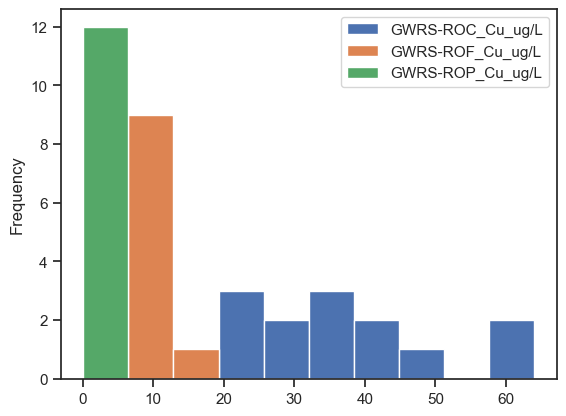

<Figure size 640x480 with 0 Axes>

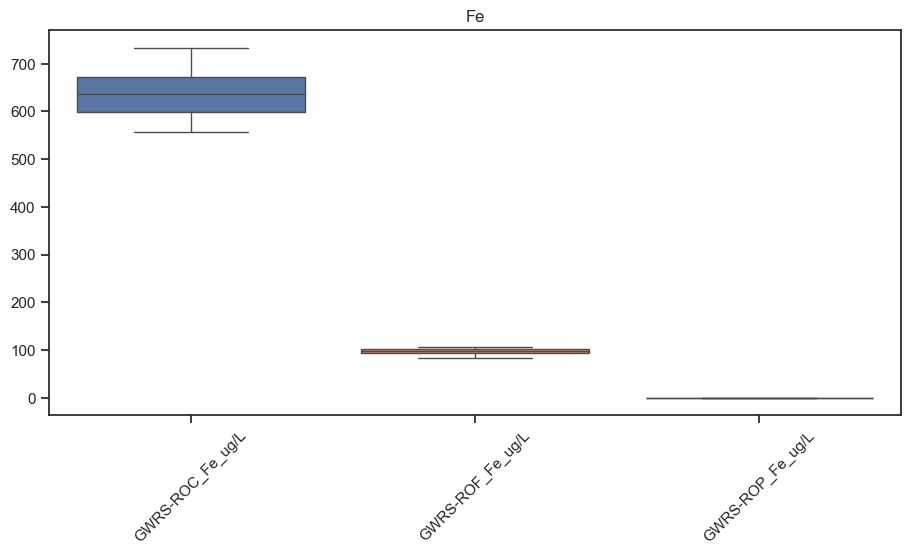

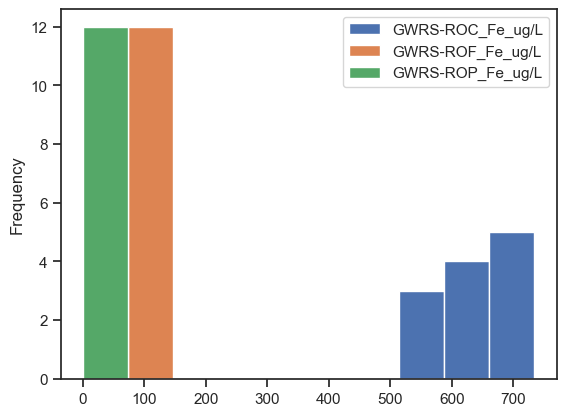

<Figure size 640x480 with 0 Axes>

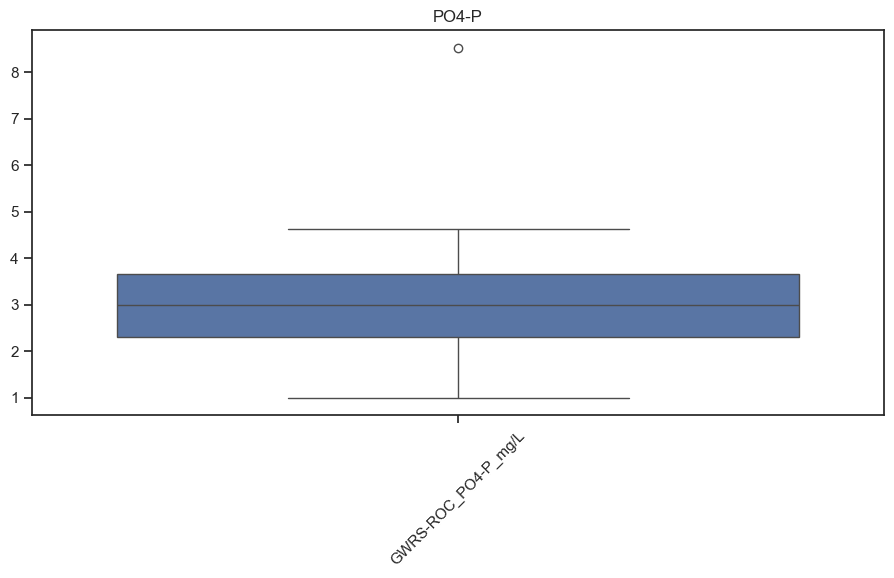

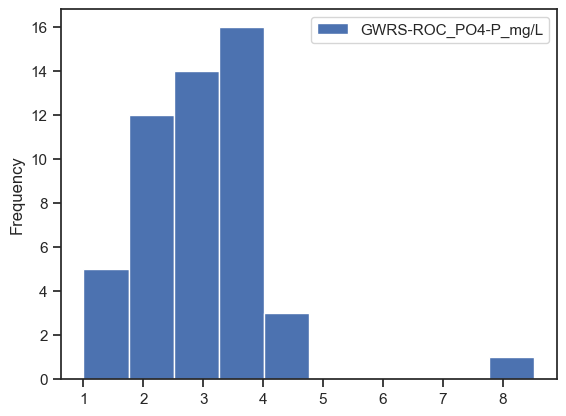

<Figure size 640x480 with 0 Axes>

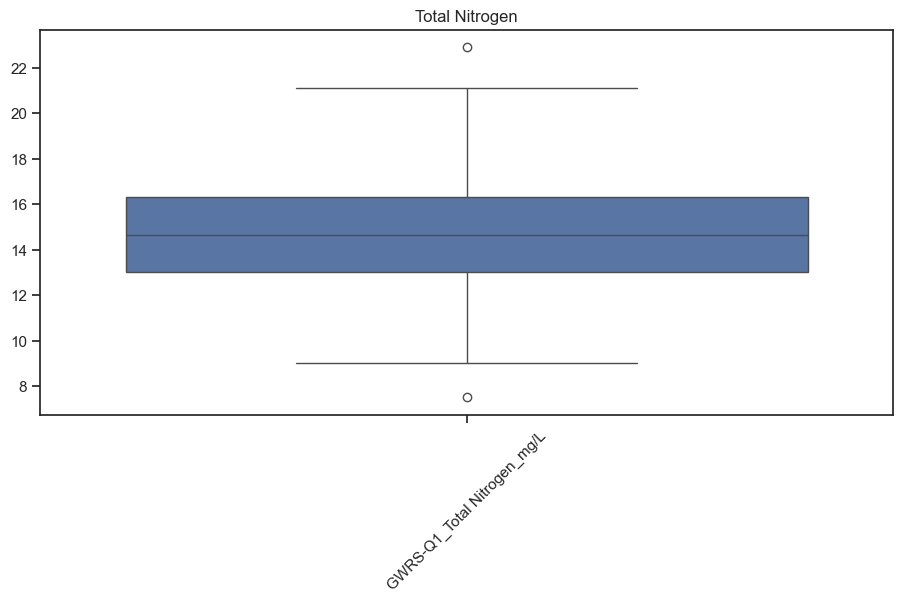

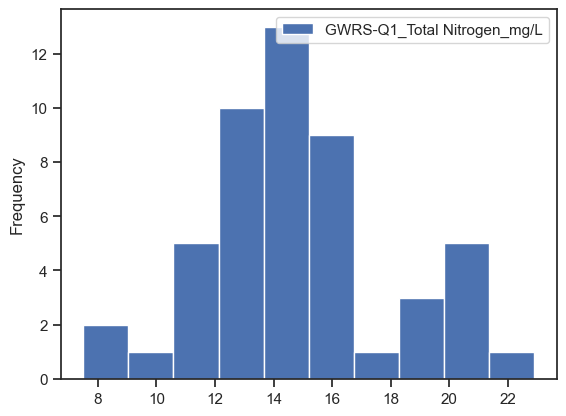

<Figure size 640x480 with 0 Axes>

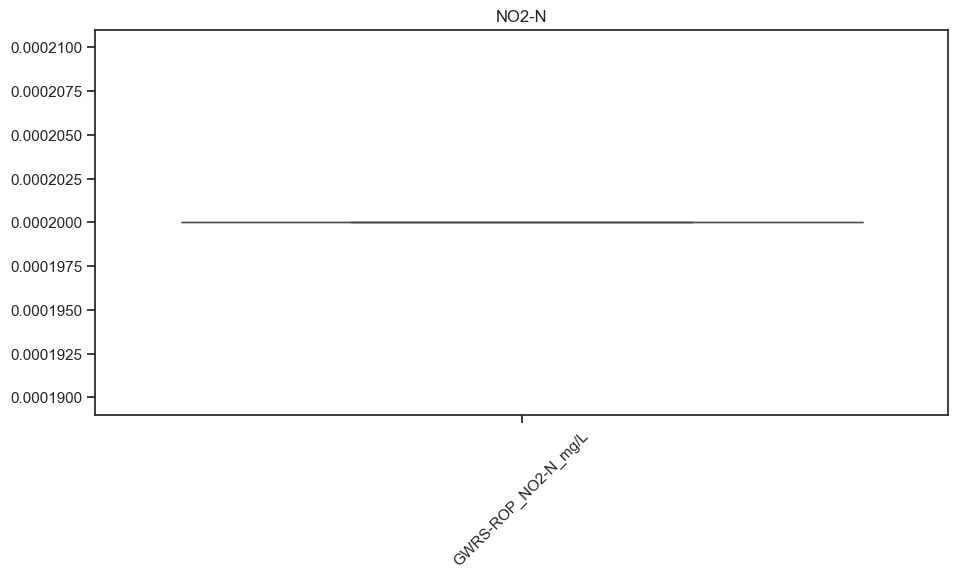

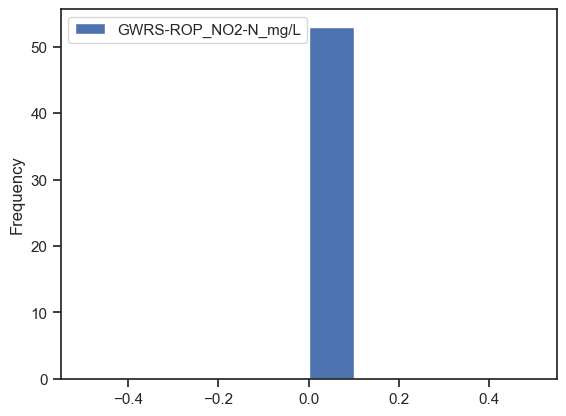

<Figure size 640x480 with 0 Axes>

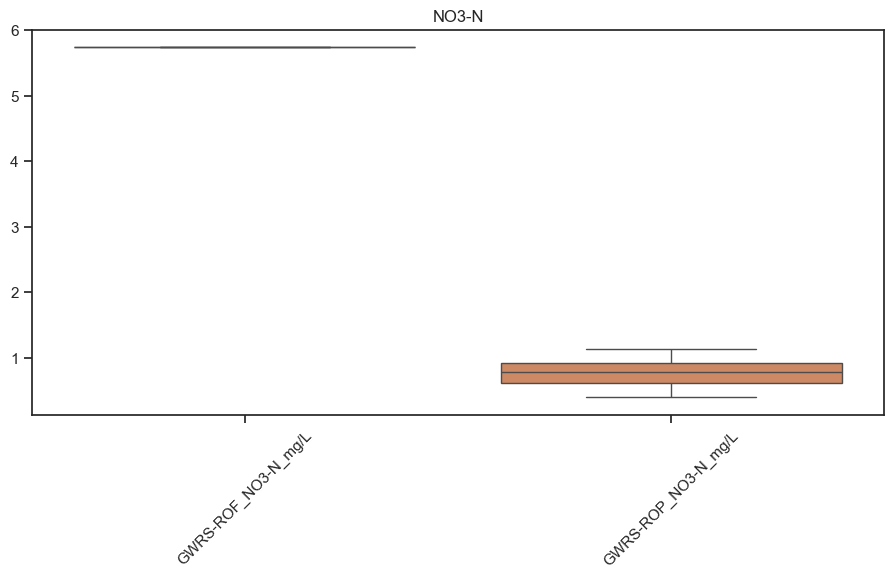

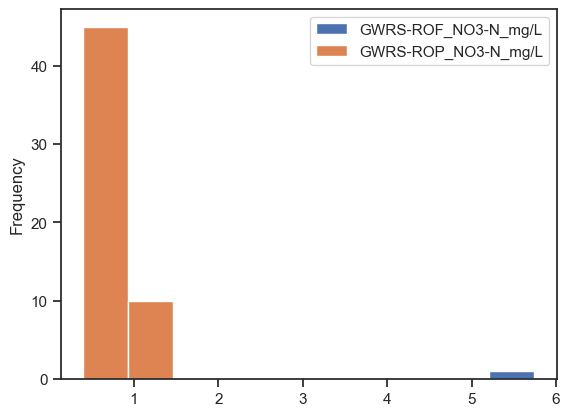

In [39]:
# Create a PDF file object
pdf_pages = PdfPages('070124_grab_WQ_distribution_plots.pdf')
for k in grab_df_dict.keys():
    Temp=grab_df_dict[k]#.sort_index(inplace=True)
    fig = plt.figure()
    try:
        #fig = sns.histplot(data=Temp, x="RESULT_VAL", bins=10)
        plt.figure(figsize=(11, 5))
        
        sns.boxplot(data=Temp)
        plt.title(label=k)
        plt.xticks(rotation=45)
        
        
        Temp.plot(kind='hist')
        
    except TypeError as e:
        print("error:",e)
    # Save the current figure to the PDF
    pdf_pages.savefig()
# Close the PDF file object
pdf_pages.close()

## graph to see yearly pattern

<Figure size 640x480 with 0 Axes>

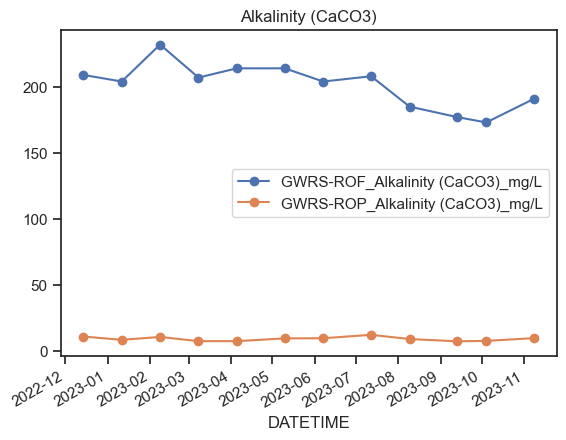

<Figure size 640x480 with 0 Axes>

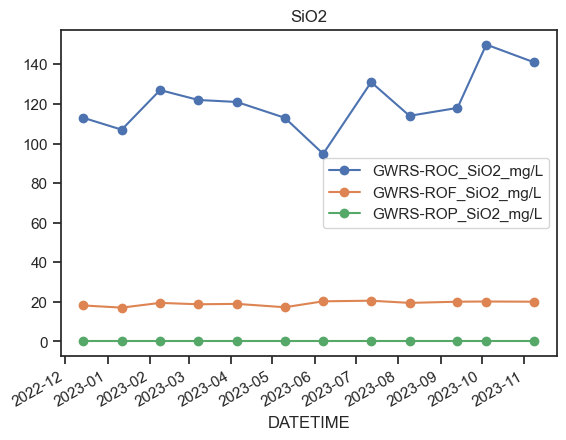

<Figure size 640x480 with 0 Axes>

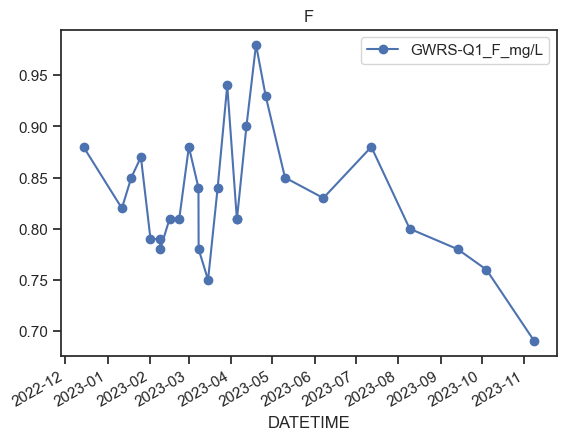

<Figure size 640x480 with 0 Axes>

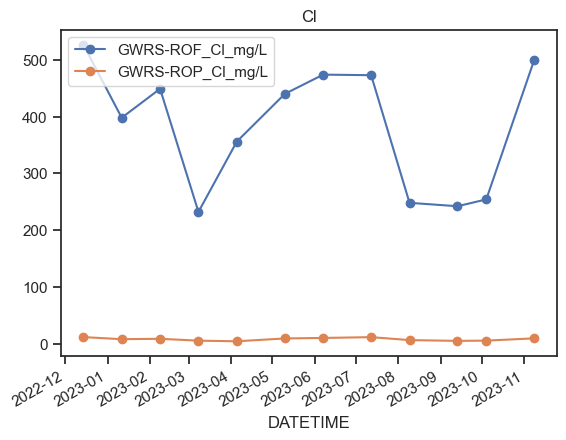

<Figure size 640x480 with 0 Axes>

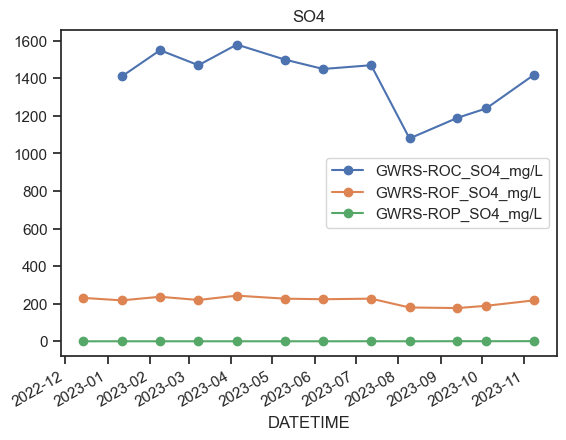

<Figure size 640x480 with 0 Axes>

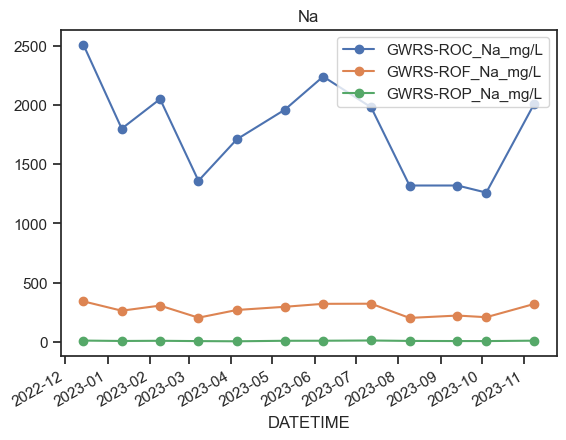

<Figure size 640x480 with 0 Axes>

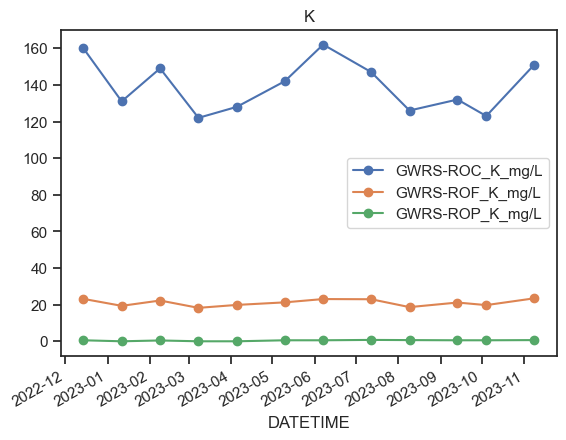

<Figure size 640x480 with 0 Axes>

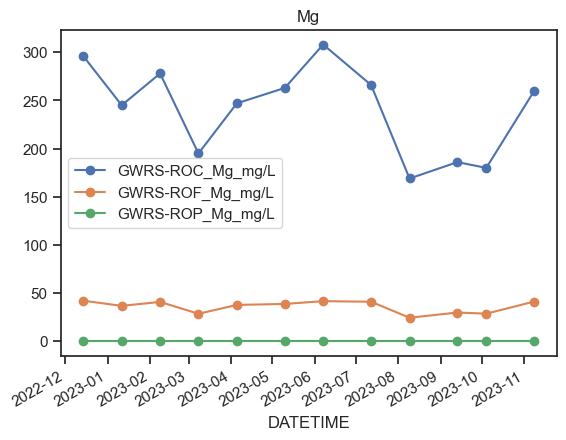

<Figure size 640x480 with 0 Axes>

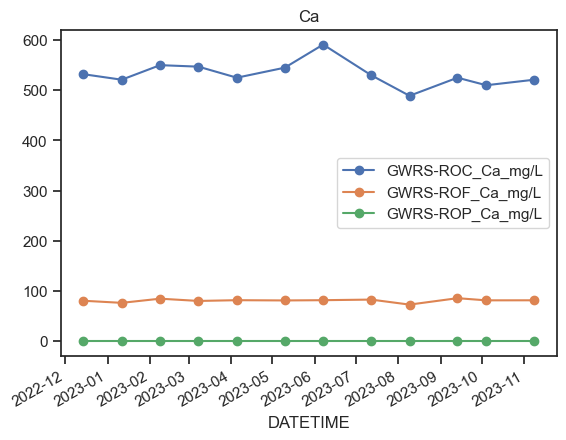

<Figure size 640x480 with 0 Axes>

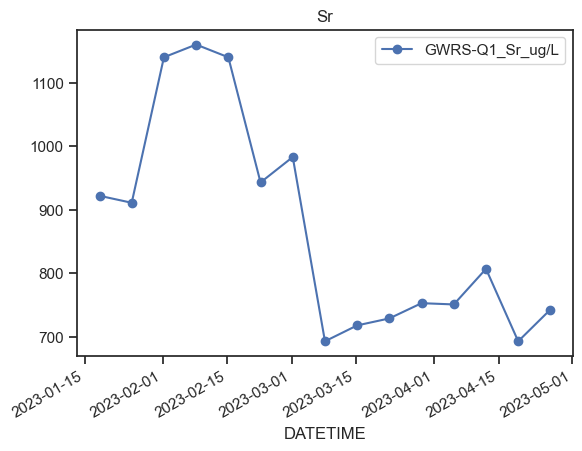

<Figure size 640x480 with 0 Axes>

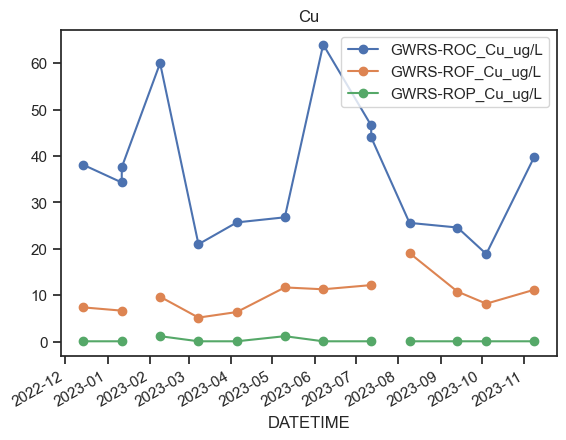

<Figure size 640x480 with 0 Axes>

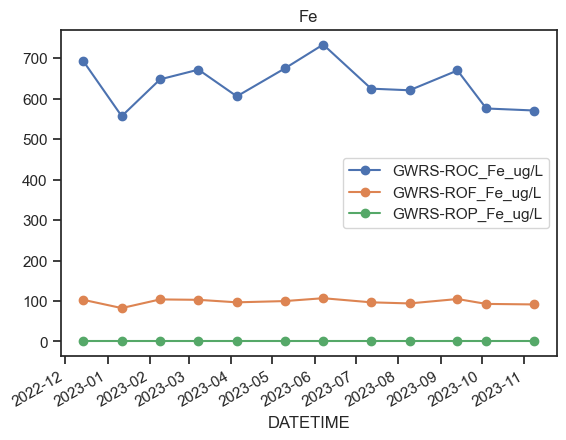

<Figure size 640x480 with 0 Axes>

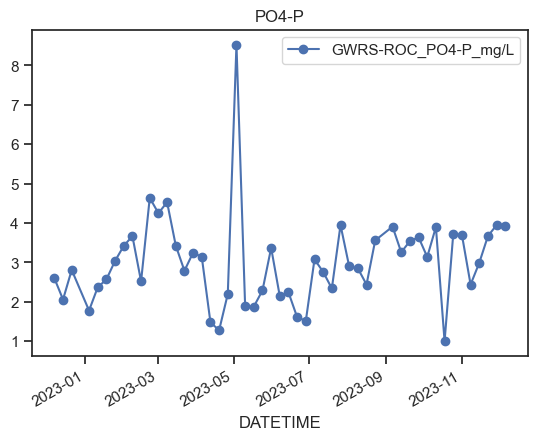

<Figure size 640x480 with 0 Axes>

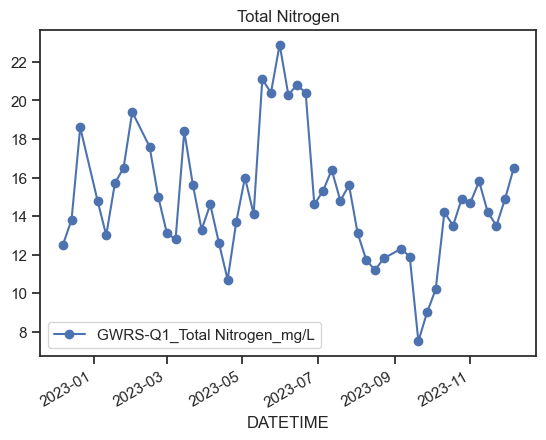

<Figure size 640x480 with 0 Axes>

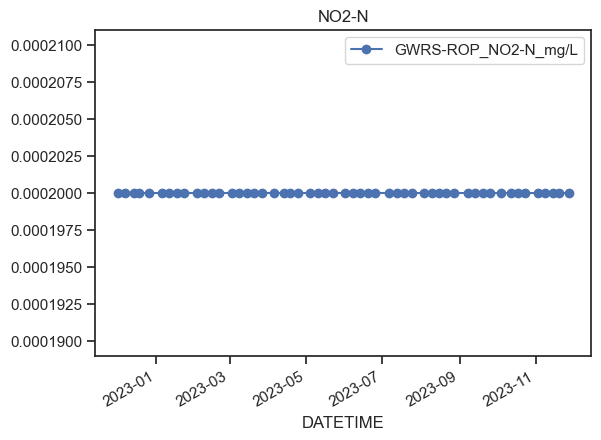

<Figure size 640x480 with 0 Axes>

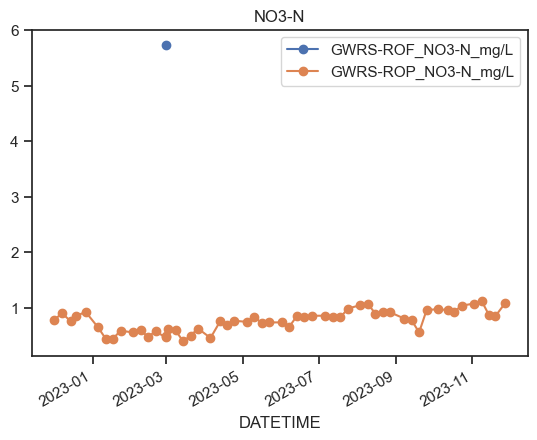

In [40]:
# Create a PDF file object
pdf_pages = PdfPages('070124_grab_WQ_yearly_plots.pdf')
for k in grab_df_dict.keys():
    Temp=grab_df_dict[k]#.sort_index(inplace=True)
    fig = plt.figure()
    try:
        fig = Temp.plot(marker='o', linestyle='-') 
        fig.set_title(label=k)
        plt.minorticks_off()
    except TypeError as e:
        print("error:",e)
    # Save the current figure to the PDF
    pdf_pages.savefig()
# Close the PDF file object
pdf_pages.close()

In [ ]:
grab_df_dict[k][['RESULT_VAL']].head()

## graph to see weekly pattern

In [ ]:
import scipy.stats as stats

In [ ]:
# Need to update the following script
weekly_df_dict={}
# Create a PDF file object
pdf_pages2 = PdfPages('grab_WQ_weeklyavg_plots.pdf')
for k in grab_df_dict.keys():
    #print(k)
    df = grab_df_dict[k][['RESULT_VAL','DayOfWeek']]
    #df.reset_index(inplace=True)
    # Aggregate data by day of the week and calculate the average
    avg_by_day = df.groupby('DayOfWeek')['RESULT_VAL'].mean()
    weekly_df_dict[k] = avg_by_day
    # Calculate 95% confidence interval
    sem_by_day = df.groupby('DayOfWeek')['RESULT_VAL'].sem()  # Standard error of the mean
    ci_by_day = 1.96 * sem_by_day  # 95% confidence interval (z-score for 95% CI is approximately 1.96)
    upper_bound = avg_by_day + ci_by_day
    lower_bound = avg_by_day - ci_by_day
    # Plot the data
    plt.figure(figsize=(10, 6))
   # plt.plot(avg_by_day.index, avg_by_day.values, marker='o', linestyle='-')
    plt.errorbar(avg_by_day.index, avg_by_day.values, yerr=ci_by_day.values, marker='o', linestyle='-', capsize=20)
    #plt.fill_between(avg_by_day.index, lower_bound, upper_bound, alpha=0.2)
    plt.xlabel('Day of the Week')
    plt.ylabel('Average y')
    plt.title(k+' weekly avg')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True)
    #plt.show()
    # Save the current figure to the PDF
    pdf_pages2.savefig(plt.gcf())
#weekly_df_dict[k].head()
# Close the PDF file object
pdf_pages2.close()

In [ ]:
upper_bound, lower_bound